## MUFGデータサイエンスコンペ
## sub12_01_1 public_f1_score=0.87296 モデル

In [79]:
# 基本ライブラリ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# clsはLightGBMメイン、アンサンブル用にRandomForest、スタッキング用にLogistic回帰を使用
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# 特徴量生成の一部にNMFを使用
from sklearn.decomposition import NMF

# GBDTとRandomForestなので、エンコーディングはラベルエンコーディングのみ
from sklearn.preprocessing import LabelEncoder

# 不均衡対策にunder_samplingを実施
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imblearn_pipeline

# データ分割、クロスバリデーション関連ツール
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

# 可視化関連メトリックス 
from sklearn.metrics import f1_score, precision_recall_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# その他利用メソッドをインポート
from datetime import timedelta
from scipy.stats import hmean

# 警告文非表示
import warnings
warnings.filterwarnings('ignore')

# 表示列数、行数を拡大
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 100)

# グラフスタイルをseabornのwhiteに設定
sns.set(style='white')


In [80]:
# データの読み込み
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


## データ概観

In [81]:

display(df.info())
display(df.head())
display(df_test.info())
display(df_test.head())

# 欠損値      train    test
# children      2        2
# country     400       88
# agent     13053     3287
# company   90080    22513

# 目的変数is_canceled,とIDを除く28特徴量のうち8つが日付に関するもの

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95512 entries, 0 to 95511
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              95512 non-null  int64  
 1   hotel                           95512 non-null  object 
 2   is_canceled                     95512 non-null  int64  
 3   lead_time                       95512 non-null  int64  
 4   arrival_date_year               95512 non-null  int64  
 5   arrival_date_month              95512 non-null  object 
 6   arrival_date_week_number        95512 non-null  int64  
 7   arrival_date_day_of_month       95512 non-null  int64  
 8   stays_in_weekend_nights         95512 non-null  int64  
 9   stays_in_week_nights            95512 non-null  int64  
 10  adults                          95512 non-null  int64  
 11  children                        95510 non-null  float64
 12  babies                          

None

,ID,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,1,City Hotel,1,4,2016,February,8,15,1,3,3,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,No Deposit,28.0,NaN,0,Transient,92.65,0,1
1,2,City Hotel,1,175,2017,June,23,9,0,2,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,No Deposit,3.0,NaN,0,Transient-Party,99.00,0,0
2,3,City Hotel,1,34,2015,December,50,8,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,1,0,A,A,Non Refund,19.0,NaN,0,Transient,90.00,0,0
3,4,City Hotel,1,61,2017,January,4,25,0,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,Non Refund,326.0,NaN,0,Transient,80.00,0,0
4,5,City Hotel,0,16,2016,December,52,22,2,3,2,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,A,D,No Deposit,89.0,NaN,0,Transient,70.72,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23878 entries, 0 to 23877
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              23878 non-null  int64  
 1   hotel                           23878 non-null  object 
 2   lead_time                       23878 non-null  int64  
 3   arrival_date_year               23878 non-null  int64  
 4   arrival_date_month              23878 non-null  object 
 5   arrival_date_week_number        23878 non-null  int64  
 6   arrival_date_day_of_month       23878 non-null  int64  
 7   stays_in_weekend_nights         23878 non-null  int64  
 8   stays_in_week_nights            23878 non-null  int64  
 9   adults                          23878 non-null  int64  
 10  children                        23876 non-null  float64
 11  babies                          23878 non-null  int64  
 12  meal                            

None

,ID,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,95513,Resort Hotel,103,2016,February,7,10,2,4,1,0.0,0,BB,NLD,Online TA,TA/TO,0,0,0,A,D,No Deposit,240.0,NaN,0,Transient,35.10,0,0
1,95514,City Hotel,54,2017,May,18,3,0,4,2,0.0,0,SC,FRA,Online TA,TA/TO,0,0,0,A,A,No Deposit,9.0,NaN,0,Transient,126.00,0,0
2,95515,Resort Hotel,94,2015,July,28,5,4,6,3,0.0,0,BB,PRT,Direct,Direct,0,0,0,D,C,No Deposit,NaN,NaN,0,Transient,124.45,1,1
3,95516,City Hotel,13,2016,April,18,26,0,3,2,0.0,0,HB,DEU,Offline TA/TO,TA/TO,0,0,0,A,A,No Deposit,58.0,NaN,0,Transient-Party,96.00,0,0
4,95517,City Hotel,86,2016,January,4,22,0,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,Non Refund,29.0,NaN,35,Transient,85.00,0,0


In [82]:
# Descriptive statistics of the dataset
display(df.describe())
display(df.describe(include='object'))
display(df_test.describe())
display(df_test.describe(include='object'))

# 訓練データとテストデータの分布に顕著な相違はないが、countryの要素数が多く差が目立つ
# adrは訓練データにのみマイナス値がある

,ID,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,95512.000000,95512.000000,95512.000000,95512.000000,95512.000000,95512.000000,95512.000000,95512.000000,95512.000000,95510.00000,95512.000000,95512.000000,95512.00000,95512.000000,82459.000000,5432.000000,95512.000000,95512.000000,95512.000000,95512.000000
mean,47756.500000,0.370414,104.018165,2016.160043,27.115807,15.782195,0.927171,2.500335,1.855694,0.10468,0.007873,0.031912,0.08578,0.136988,87.007846,190.082290,2.299355,101.643916,0.062484,0.571289
std,27572.083793,0.482918,106.889162,0.708306,13.606734,8.778795,0.999856,1.909299,0.590307,0.40034,0.098681,0.175767,0.82883,1.504391,110.866652,132.077053,17.630724,48.158325,0.245513,0.791696
min,1.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,1.000000,8.000000,0.000000,-6.380000,0.000000,0.000000
25%,23878.750000,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.00000,0.000000,0.000000,0.00000,0.000000,9.000000,67.000000,0.000000,69.000000,0.000000,0.000000
50%,47756.500000,0.000000,69.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.00000,0.000000,0.000000,0.00000,0.000000,14.000000,179.000000,0.000000,94.500000,0.000000,0.000000
75%,71634.250000,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.00000,0.000000,0.000000,0.00000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,95512.000000,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.00000,10.000000,1.000000,26.00000,72.000000,535.000000,543.000000,391.000000,510.000000,8.000000,5.000000


,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type
count,95512,95512,95512,95112,95512,95512,95512,95512,95512,95512
unique,2,12,5,171,8,5,10,12,3,4
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient
freq,63355,11132,73837,38805,45190,78309,68858,59235,83701,71718


,ID,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,23878.0000,23878.000000,23878.000000,23878.000000,23878.000000,23878.000000,23878.000000,23878.000000,23876.000000,23878.000000,23878.000000,23878.000000,23878.000000,20591.000000,1365.000000,23878.000000,23878.000000,23878.000000,23878.000000
mean,107451.5000,103.984421,2016.142600,27.362635,15.862426,0.929307,2.500168,1.859243,0.100729,0.008250,0.031912,0.092470,0.137532,85.434073,186.021245,2.408326,102.579943,0.062652,0.571656
std,6893.1292,106.761006,0.703989,13.597248,8.788852,0.993649,1.904266,0.532793,0.391359,0.092291,0.175770,0.903703,1.469324,110.398647,129.959148,17.450058,59.092037,0.244406,0.797210
min,95513.0000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000
25%,101482.2500,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,51.000000,0.000000,70.000000,0.000000,0.000000
50%,107451.5000,68.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,174.000000,0.000000,95.000000,0.000000,0.000000
75%,113420.7500,162.000000,2017.000000,38.000000,24.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.000000,263.000000,0.000000,126.000000,0.000000,1.000000
max,119390.0000,629.000000,2017.000000,53.000000,31.000000,14.000000,34.000000,27.000000,3.000000,2.000000,1.000000,26.000000,71.000000,531.000000,530.000000,391.000000,5400.000000,3.000000,5.000000


,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type
count,23878,23878,23878,23790,23878,23878,23878,23878,23878,23878
unique,2,12,5,128,8,5,9,11,3,4
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient
freq,15975,2745,18473,9785,11287,19561,17136,14818,20940,17895


## EDA

In [83]:
# 説明変数Xと目的変数yを分離

X = df.drop(columns=['ID', 'is_canceled'])
y = df['is_canceled']

In [84]:
# 対目的変数検証関数（EDA用）

def vs_target(col):
    data = pd.concat([X, y], axis=1)
    return data.groupby(col)['is_canceled'].agg(['sum', 'count', 'mean'])

def count_vs_target(col):
    data = pd.concat([X, y], axis=1)
    fig, ax = plt.subplots(figsize=(20, 3), layout='constrained')
    sns.countplot(data, x=col, hue='is_canceled', ax=ax)

def boxen_vs_target(col):
    data = pd.concat([X, y], axis=1)
    fig, ax = plt.subplots(figsize=(20, 3), layout='constrained')
    sns.boxenplot(data, x=col, hue='is_canceled', ax=ax)

def hist_vs_target(col):
    data = pd.concat([X, y], axis=1)
    fig, ax = plt.subplots(figsize=(20, 3), layout='constrained')
    sns.histplot(data, x=col, hue='is_canceled', ax=ax)

# よく使うものを関数化

In [85]:
# is_canceled

df['is_canceled'].value_counts(normalize=True)

# キャンセル率陽性は37%
# 不均衡というほどでもないが、評価指標がF1スコアなのでリサンプリングが必要かもしれない

is_canceled
0    0.629586
1    0.370414
Name: proportion, dtype: float64

,sum,count,mean
hotel,,,
City Hotel,26519,63355,0.418578
Resort Hotel,8860,32157,0.275523


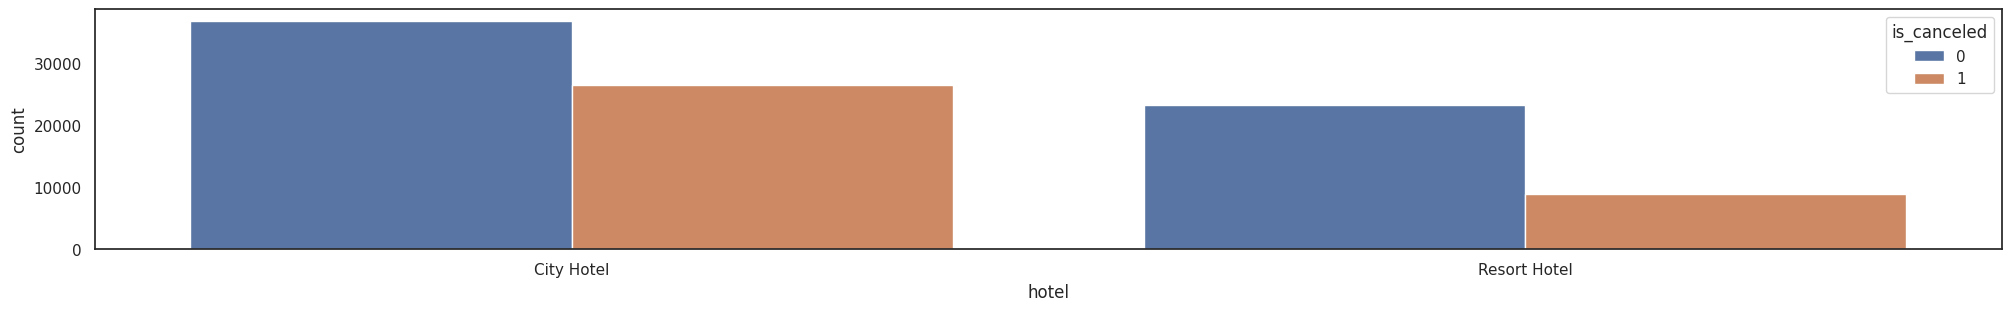

In [86]:
# hotel

display(vs_target('hotel'))
count_vs_target('hotel')

#　CityHotelとResortHotelでキャンセル状況に差がある

In [87]:
# adults, children, babies

display(vs_target('adults'))
display(vs_target(['children', 'babies']))
display(X[X['children'].isnull()])

# adultsがゼロの予約が結構ある
# children, 特にbabiesは数も少ない
# 4名以上は数も限定的でノイズの原因になるので合計する方針
# childrenの欠損値2件は特段の問題もなさそうなので一番多い0で埋める

,sum,count,mean
adults,,,
0,98,334,0.293413
1,5353,18429,0.290466
2,28177,71779,0.392552
3,1727,4910,0.351731
4,12,48,0.250000
5,2,2,1.000000
20,1,1,1.000000
26,5,5,1.000000
27,1,1,1.000000


sum  count      mean
children babies                        
0.0      0       32791  88013  0.372570
         1         104    572  0.181818
         2           2      9  0.222222
         9           0      1  0.000000
         10          0      1  0.000000
1.0      0        1219   3781  0.322401
         1          17    113  0.150442
         2           0      2  0.000000
2.0      0        1219   2933  0.415615
         1           9     26  0.346154
3.0      0          15     58  0.258621
10.0     0           1      1  1.000000

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
62593,City Hotel,1,2015,August,32,5,0,2,2,NaN,0,BB,PRT,Direct,Undefined,0,0,0,B,B,No Deposit,14.0,NaN,0,Transient-Party,12.0,0,1
72019,City Hotel,2,2015,August,32,3,1,0,2,NaN,0,BB,PRT,Undefined,Undefined,0,0,0,B,B,No Deposit,NaN,NaN,0,Transient-Party,12.0,0,1


,sum,count,mean
meal,,,
BB,27579,73837,0.373512
FB,382,630,0.606349
HB,3973,11566,0.343507
SC,3209,8539,0.375805
Undefined,236,940,0.251064


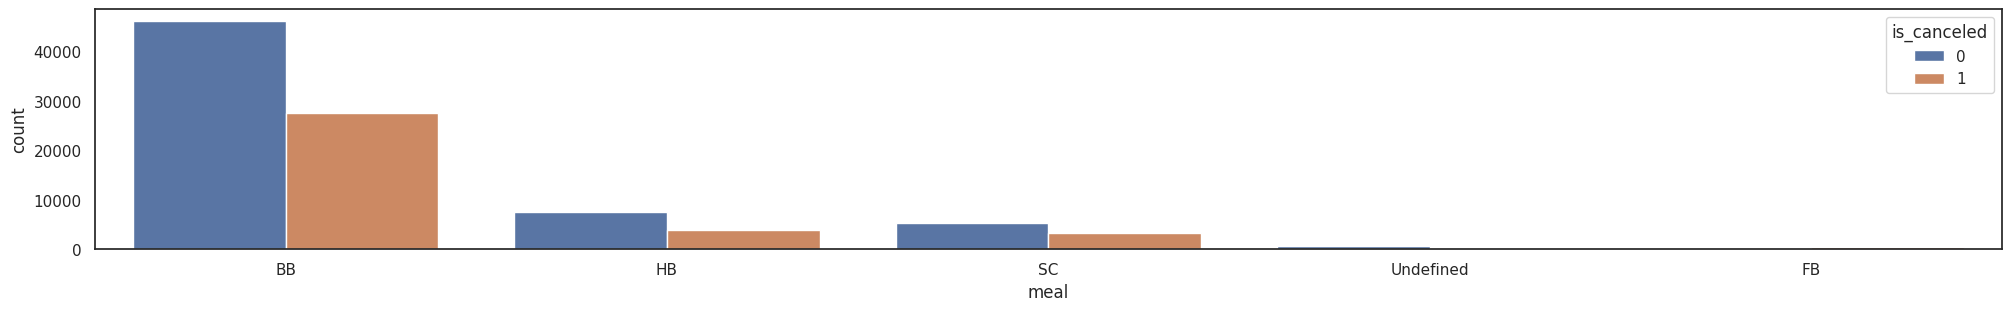

In [88]:
# meal

display(vs_target('meal'))
count_vs_target('meal')

# ホテルの料金プランやサービス内容に関連するこれらの略語は食事の提供内容を示す
# BB (Bed & Breakfast): 宿泊と朝食が含まれるプラン。通常、夜の宿泊後、翌朝に朝食が提供される
# HB (Half Board): 半日の食事付きプラン。通常、宿泊、朝食、そして昼食または夕食（どちらか一方）が含まれる
# FB (Full Board): 1日3食付きのプラン。宿泊、朝食、昼食、夕食がすべて含まれる。
# SC (Self Catering): 食事なしの宿泊のみのプラン。客は自分で食事を準備するか、外で食事を取ることが期待される
# Undefined: 食事の提供内容が定義されていない、または該当しない場合

# 1日3食付きプランが数は少ないが突出してキャンセル率が高い

,sum,count,mean
country,,,
PRT,22006,38805,0.567092
GBR,1966,9713,0.202409
FRA,1548,8346,0.185478
ESP,1731,6861,0.252296
DEU,960,5802,0.165460
ITA,1065,3031,0.351369
IRL,684,2713,0.252119
BEL,378,1881,0.200957
BRA,679,1788,0.379754


,ID,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,128.000000,140.000000,400.0,400.000000,400.000000,400.000000
mean,46344.615000,0.147500,32.415000,2015.897500,26.735000,15.232500,0.642500,2.105000,1.370000,0.032500,0.005000,0.007500,0.085000,1.482500,178.710938,173.328571,0.0,60.014125,0.210000,0.485000
std,28302.630935,0.355048,65.138778,0.661883,16.882604,9.003672,1.528245,3.543355,0.542065,0.203832,0.070622,0.086385,0.296639,3.225011,104.406621,110.103577,0.0,44.762794,0.407818,0.807096
min,72.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,9.000000,0.0,0.000000,0.000000,0.000000
25%,21173.250000,0.000000,1.000000,2015.000000,11.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,96.000000,94.000000,0.0,35.000000,0.000000,0.000000
50%,44378.500000,0.000000,4.000000,2016.000000,28.000000,15.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,240.000000,154.000000,0.0,45.500000,0.000000,0.000000
75%,71591.750000,0.000000,16.250000,2016.000000,43.000000,23.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,240.000000,269.000000,0.0,65.000000,0.000000,1.000000
max,95257.000000,1.000000,267.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,3.000000,2.000000,1.000000,1.000000,2.000000,29.000000,468.000000,490.000000,0.0,305.000000,1.000000,5.000000


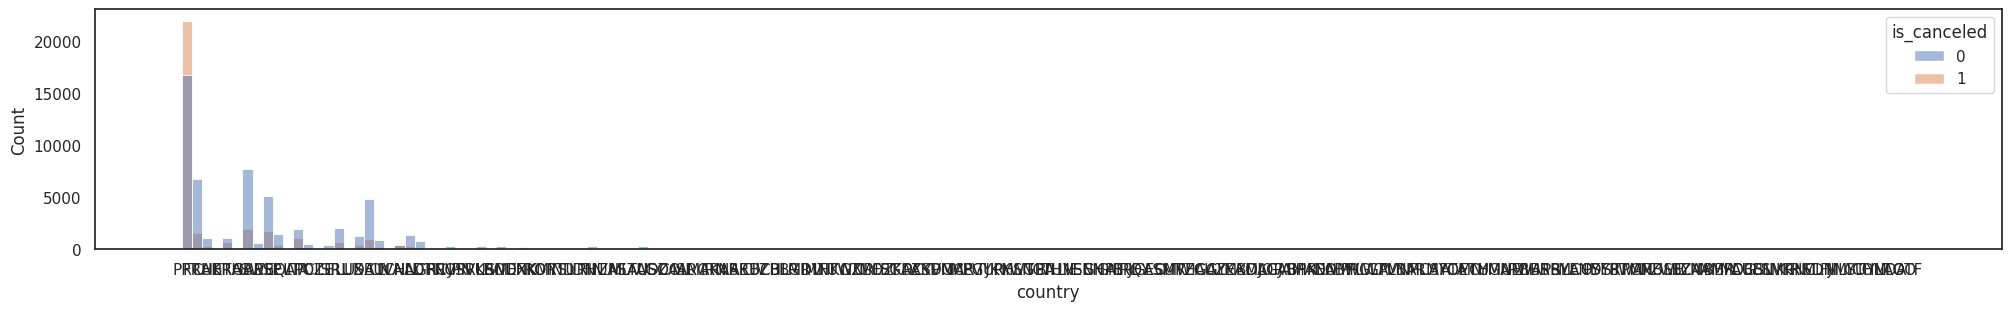

In [89]:
# country

display(vs_target('country').sort_values('count', ascending=False).head(20))
display(df[df['country'].isnull()].describe())
hist_vs_target('country')

# 4割の客がポルトガルでキャンセル率も著しく高い、これがポルトガルのホテルデータであることを示している
# 欠損値のキャンセル率が低く、独立要素とする方針
# 要素数が多く、テストデータとバラつきも大きいので少数のものをothersで纏める方針

,sum,count,mean
market_segment,,,
Aviation,40,184,0.217391
Complementary,76,598,0.127090
Corporate,800,4214,0.189843
Direct,1550,10127,0.153056
Groups,9655,15807,0.610805
Offline TA/TO,6684,19391,0.344696
Online TA,16573,45190,0.366740
Undefined,1,1,1.000000


,sum,count,mean
distribution_channel,,,
Corporate,1175,5300,0.221698
Direct,2043,11747,0.173917
GDS,32,153,0.209150
TA/TO,32127,78309,0.410259
Undefined,2,3,0.666667


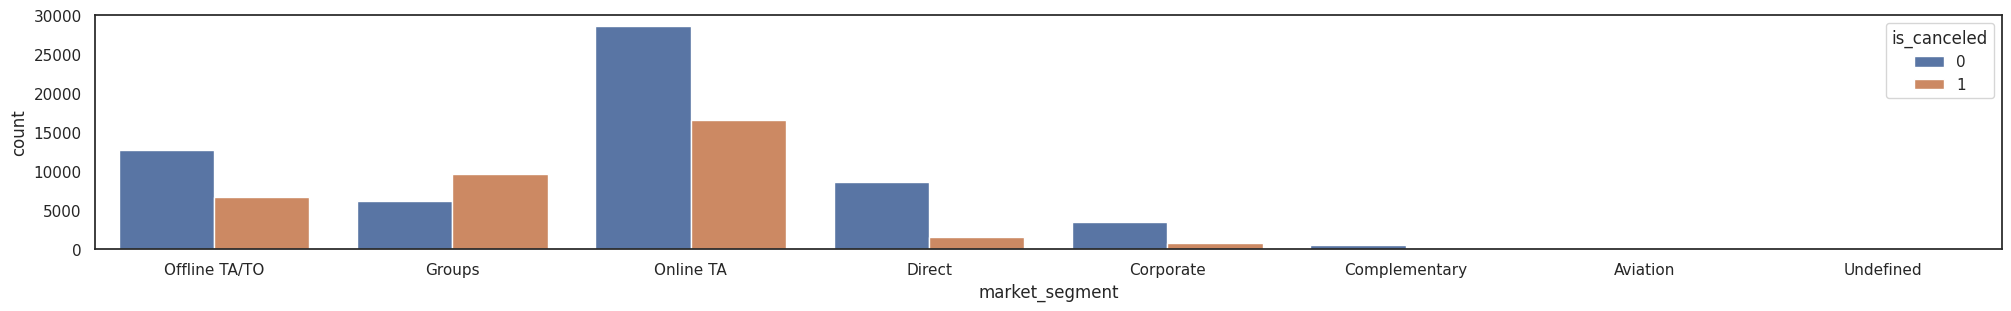

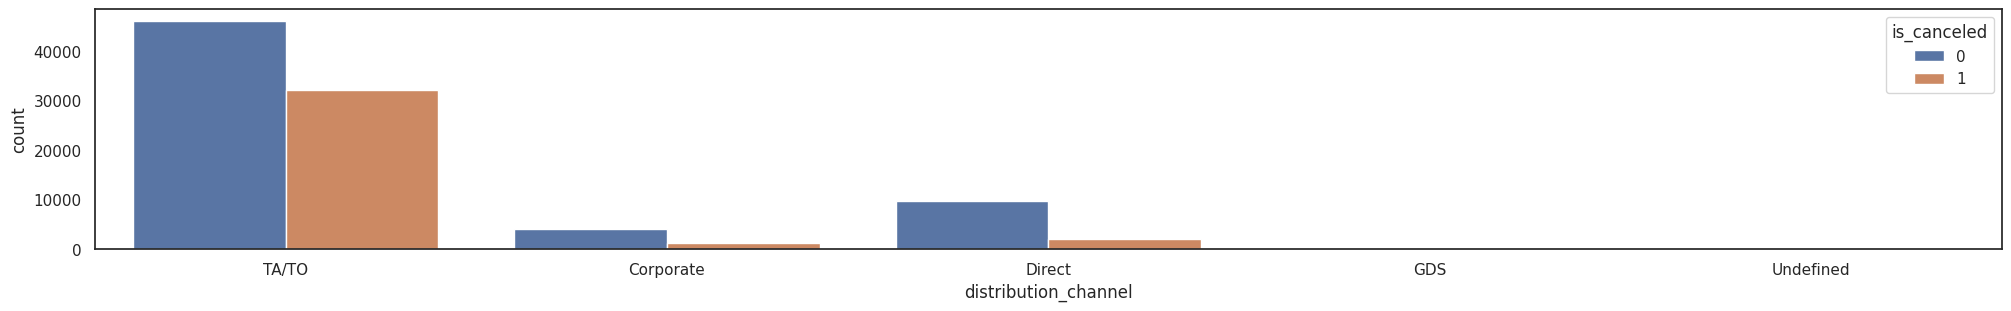

In [90]:
# market_segment, distribution_channel

display(vs_target('market_segment'))
display(vs_target('distribution_channel'))
count_vs_target('market_segment')
count_vs_target('distribution_channel')

# 似た要素のカテゴリで少数要素も多いためノイズを警戒して統合方針

,sum,count,mean
is_repeated_guest,,,
0,34930,92464,0.377769
1,449,3048,0.147310


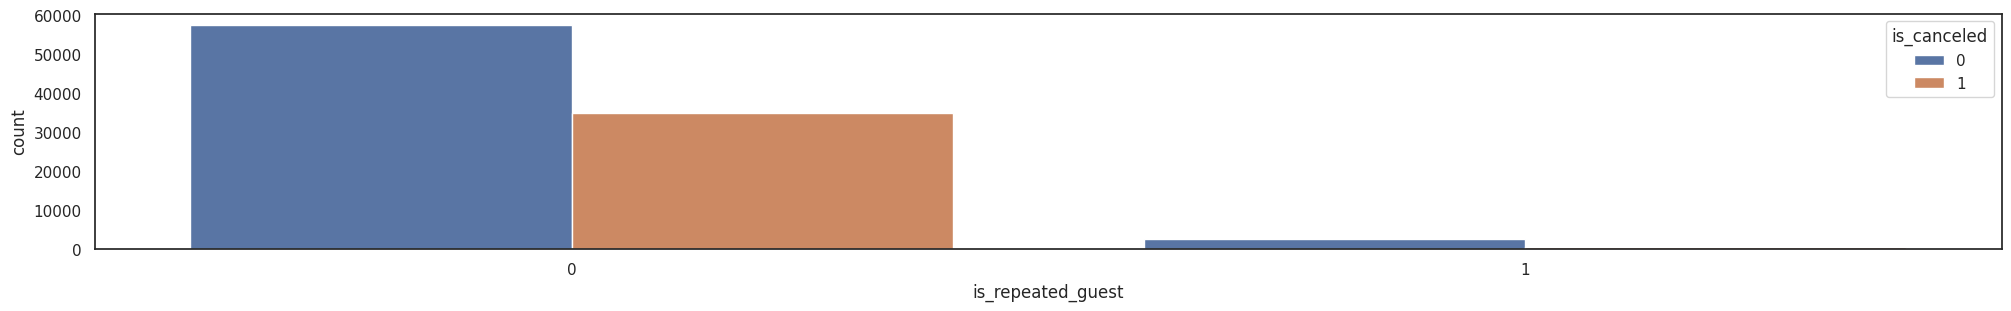

In [91]:
# is_repeated_guest

display(vs_target('is_repeated_guest'))
count_vs_target('is_repeated_guest')

# リピート客のキャンセル率は低いがデータ数が少ない

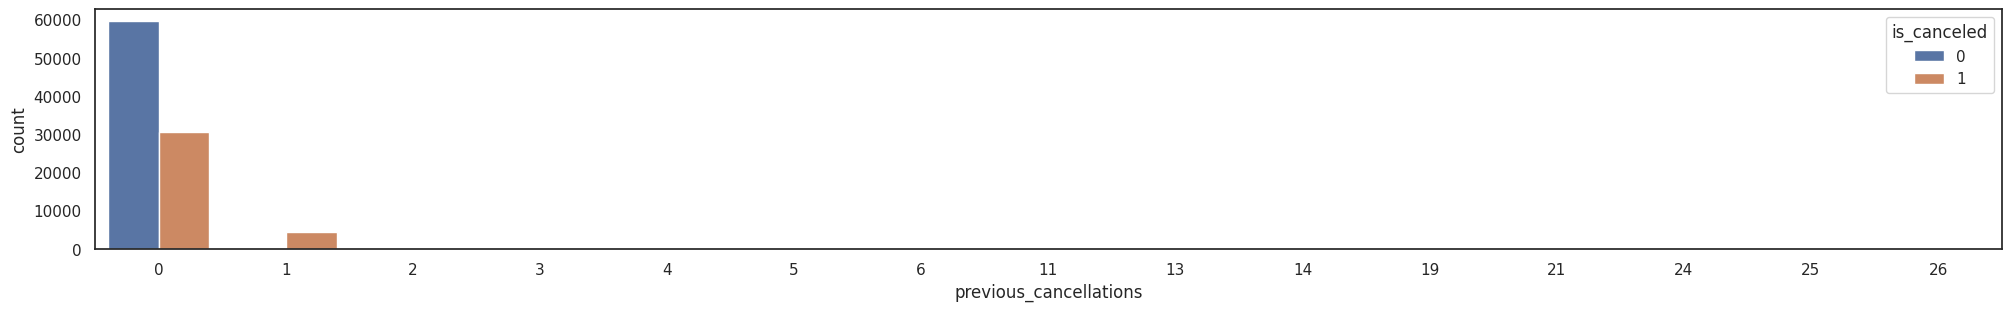

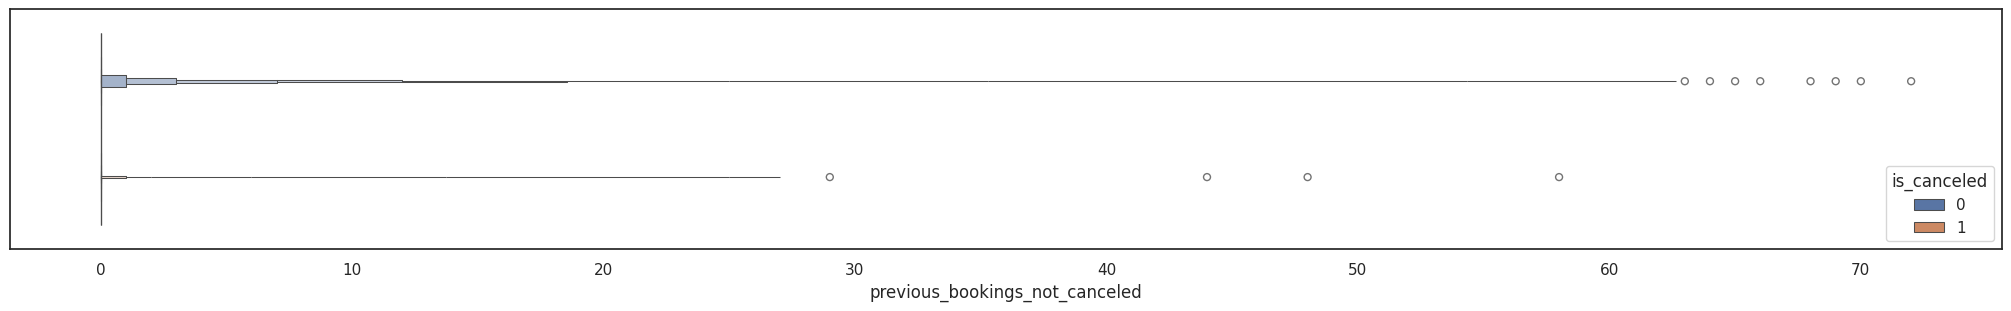

In [92]:
# previous_cancellations, previous_bookings_not_canceled

count_vs_target('previous_cancellations')
boxen_vs_target('previous_bookings_not_canceled')

# 類似特徴量であるほか外れ値もあり、整理が必要

sum  count      mean
reserved_room_type assigned_room_type                        
A                  A                   26402  58873  0.448457
                   B                     124    918  0.135076
                   C                     111   1150  0.096522
                   D                     253   6071  0.041674
                   E                      37    940  0.039362
                   F                      22    335  0.065672
                   G                       3    150  0.020000
                   H                       5     80  0.062500
                   I                       2    166  0.012048
                   K                       6    175  0.034286
B                  A                       2     90  0.022222
                   B                     305    791  0.385588
                   D                       0      4  0.000000
                   E                       0      2  0.000000
                   F                       0      2  0.000000
                   G                       0      7  0.000000
                   K                       0      2  0.000000
C                  A                       0      4  0.000000
                   B                       0      1  0.000000
                   C                     226    697  0.324247
                   D                       0      5  0.000000
                   E                       0      2  0.000000
                   F                       0      1  0.000000
                   G                       0      8  0.000000
                   H                       0      8  0.000000
                   I                       0      8  0.000000
D                  A                       7    245  0.028571
                   B                       0     21  0.000000
                   C                       1     26  0.038462
                   D                    4802  14192  0.338360
                   E                      27    526  0.051331
                   F                       4    171  0.023392
                   G                       2     67  0.029851
                   H                       0      6  0.000000
                   I                       1     57  0.017544
                   K                       3     33  0.090909
E                  A                       3     13  0.230769
                   B                       0      2  0.000000
                   C                       0      5  0.000000
                   D                       0     17  0.000000
                   E                    1509   4714  0.320110
                   F                      15    312  0.048077
                   G                       3     82  0.036585
                   H                       1      4  0.250000
                   I                       0     31  0.000000
                   K                       0     13  0.000000
F                  A                       0      5  0.000000
                   B                       0     14  0.000000
                   D                       1      3  0.333333
                   E                       0     25  0.000000
                   F                     687   2152  0.319238
                   G                       5     93  0.053763
                   H                       0      3  0.000000
                   I                       0      6  0.000000
                   K                       0      3  0.000000
G                  A                       1      4  0.250000
                   B                       0      2  0.000000
                   C                       0      2  0.000000
                   E                       0      4  0.000000
                   F                       1     11  0.090909
                   G                     607   1636  0.371027
                   H                       0      7  0.000000
                   I                       1     15  0.066667
           

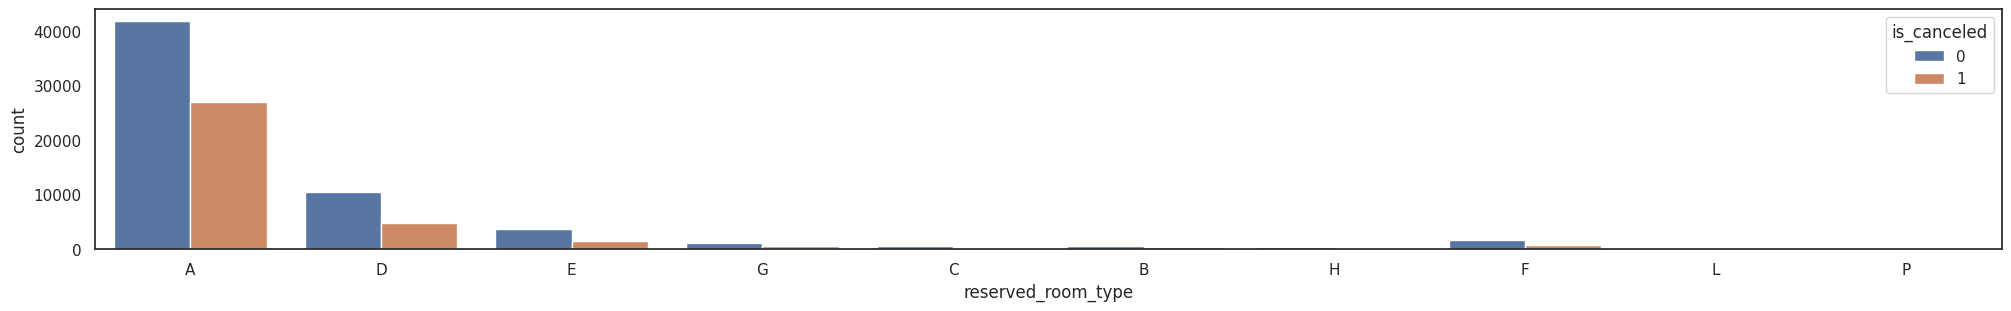

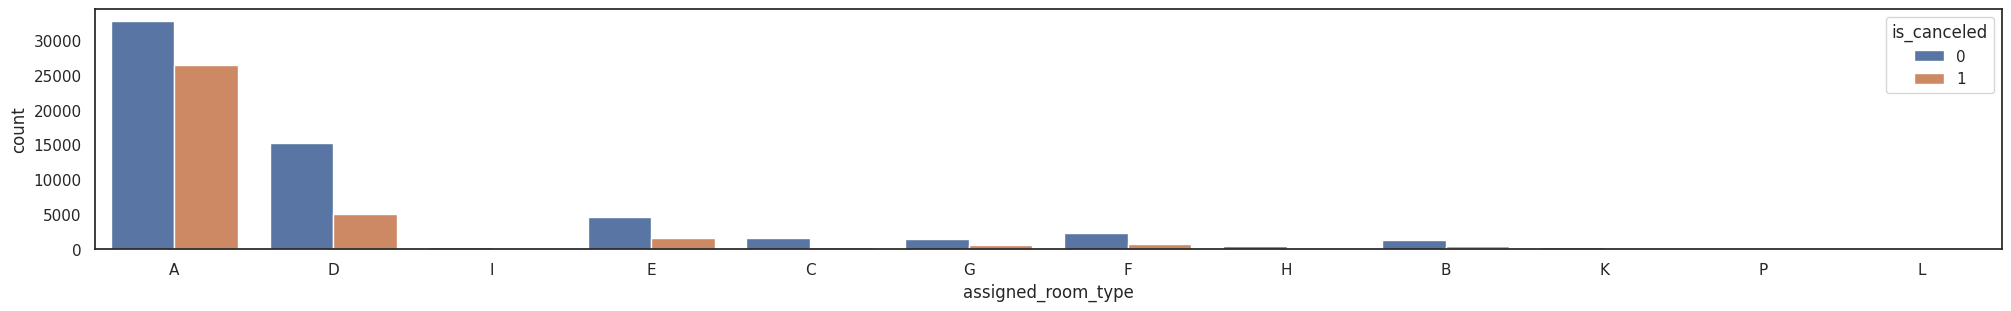

In [93]:
# reserved_room_type, assigned_room_type

count_vs_target('reserved_room_type')
count_vs_target('assigned_room_type')

vs_target(['reserved_room_type', 'assigned_room_type'])

# 変更になっているもののキャンセル率が著しく低い
# ⇒ 変更はarrival_dateに行われる、つまり、そこまでキャンセルされていない予約ということ

In [94]:
# deposit_type

vs_target('deposit_type')

# No Deposit: "デポジットなし"。予約時に保証金やデポジットを支払う必要がない条件を指す。
#   キャンセルや変更が生じた場合にも、追加の料金は発生しないことが多い。
# Non Refund: "返金不可"。予約時に支払われるデポジットや保証金は、キャンセルや変更が生じた場合に返金されない条件を指す。
#   このような条件の下での予約は、キャンセルのリスクが高い場合や、特定のプロモーションや割引が適用される場合などに設定されることが多い。
# Refundable: "返金可能"。予約時に支払われるデポジットや保証金は、特定の条件の下で返金される可能性があることを指す。
#   キャンセルや変更の際の返金条件や期限には、ホテルや予約サービスによって異なるルールが適用されることがある。

# Non Refundがほぼ全てキャンセルされている

,sum,count,mean
deposit_type,,,
No Deposit,23750,83701,0.283748
Non Refund,11597,11680,0.992894
Refundable,32,131,0.244275


,ID,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,13053.000000,13053.000000,13053.000000,13053.000000,13053.000000,13053.000000,13053.000000,13053.000000,13053.000000,13052.000000,13053.000000,13053.000000,13053.000000,13053.000000,0.0,5262.000000,13053.000000,13053.000000,13053.000000,13053.000000
mean,47360.293726,0.244771,55.133226,2016.163104,25.949284,15.840343,0.608289,1.937792,1.583467,0.060834,0.009806,0.144411,0.147476,0.849383,NaN,187.610224,0.419903,84.190530,0.119513,0.358232
std,27760.171950,0.429968,86.560898,0.714316,15.414526,8.685798,0.908476,1.845709,0.945428,0.304953,0.100086,0.351520,1.235864,3.841918,NaN,132.153096,5.516570,50.433272,0.338730,0.710507
min,50.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,8.000000,0.000000,0.000000,0.000000,0.000000
25%,23171.000000,0.000000,1.000000,2016.000000,12.000000,9.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,62.000000,0.000000,50.000000,0.000000,0.000000
50%,46923.000000,0.000000,11.000000,2016.000000,24.000000,16.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,174.000000,0.000000,75.000000,0.000000,0.000000
75%,71384.000000,0.000000,73.000000,2017.000000,41.000000,23.000000,1.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,251.000000,0.000000,110.000000,0.000000,1.000000
max,95506.000000,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,3.000000,2.000000,1.000000,24.000000,72.000000,NaN,543.000000,185.000000,508.000000,8.000000,5.000000


,ID,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,90080.000000,90080.000000,90080.000000,90080.000000,90080.000000,90080.000000,90080.000000,90080.000000,90080.000000,90078.000000,90080.000000,90080.000000,90080.000000,90080.000000,82289.000000,0.0,90080.000000,90080.000000,90080.000000,90080.000000
mean,47803.947280,0.382205,107.377209,2016.160158,27.211923,15.790175,0.953963,2.538499,1.888988,0.109994,0.008182,0.019094,0.081150,0.036512,86.774271,NaN,2.420848,103.725608,0.059747,0.590309
std,27567.666815,0.485929,107.291912,0.708008,13.475684,8.792402,1.004293,1.914375,0.579304,0.409597,0.100784,0.136857,0.839756,0.526930,110.743787,NaN,18.101418,48.069041,0.240644,0.798019
min,1.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,0.000000,-6.380000,0.000000,0.000000
25%,23951.750000,0.000000,21.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,NaN,0.000000,71.407500,0.000000,0.000000
50%,47820.500000,0.000000,74.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,NaN,0.000000,95.700000,0.000000,0.000000
75%,71682.250000,1.000000,164.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,NaN,0.000000,127.500000,0.000000,1.000000
max,95512.000000,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,50.000000,535.000000,NaN,391.000000,510.000000,8.000000,5.000000


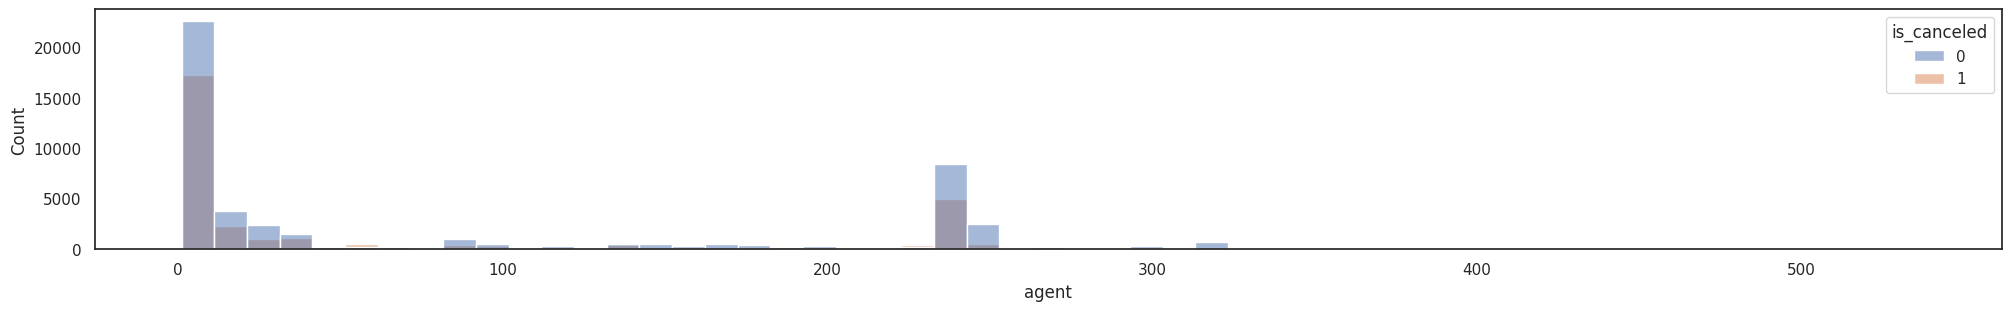

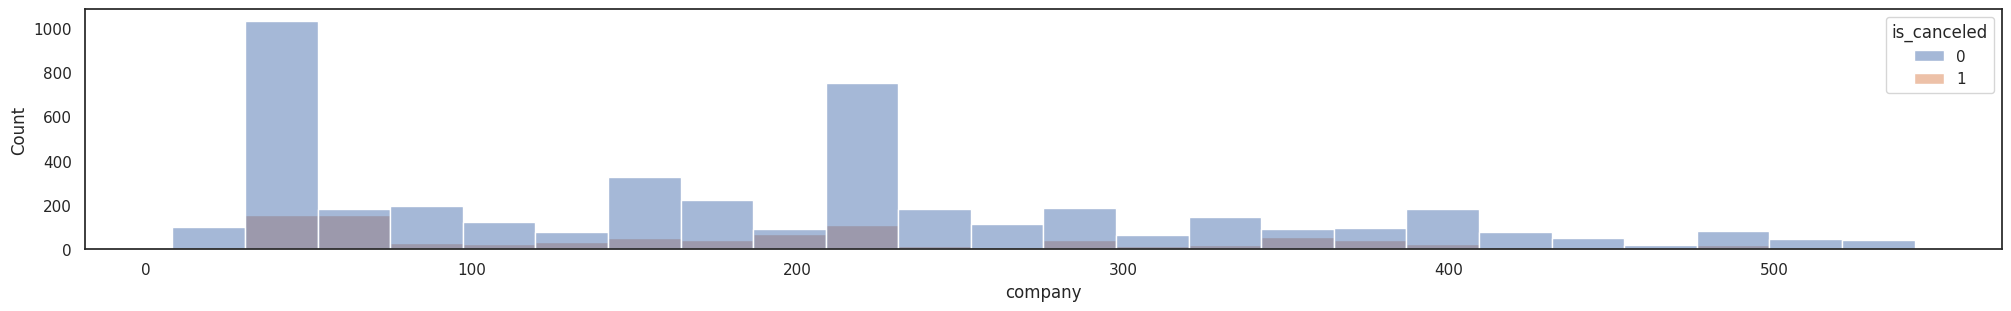

In [95]:
# agent, company

agent_missing = df[df['agent'].isnull()]
company_missing = df[df['company'].isnull()]

display(agent_missing.describe())
display(company_missing.describe())

hist_vs_target('agent')
hist_vs_target('company')

# 欠損値はagentのキャンセル率がやや低め、companyは大部分が欠損しており欠損値の分布に特段の特徴はみられない
# どちらも特定のIDに要素が偏っており、キャンセル率にも違いが大きい


In [96]:
# customer_type

vs_target('customer_type')

# Transient: 一時的な顧客で、一度限りの予約を行う
# Contract: 契約を結んでいる顧客で、一定の期間または回数での予約があることが特徴
# Transient-Party: 一時的な顧客であるが、一緒に予約を行うグループやパーティが存在することを示す
# Group: グループ予約を行う顧客で、複数の部屋やユニットを予約する

# 一時的顧客以外は各々キャンセル率が低い

,sum,count,mean
customer_type,,,
Contract,1036,3291,0.314798
Group,44,458,0.096070
Transient,29165,71718,0.406662
Transient-Party,5134,20045,0.256124


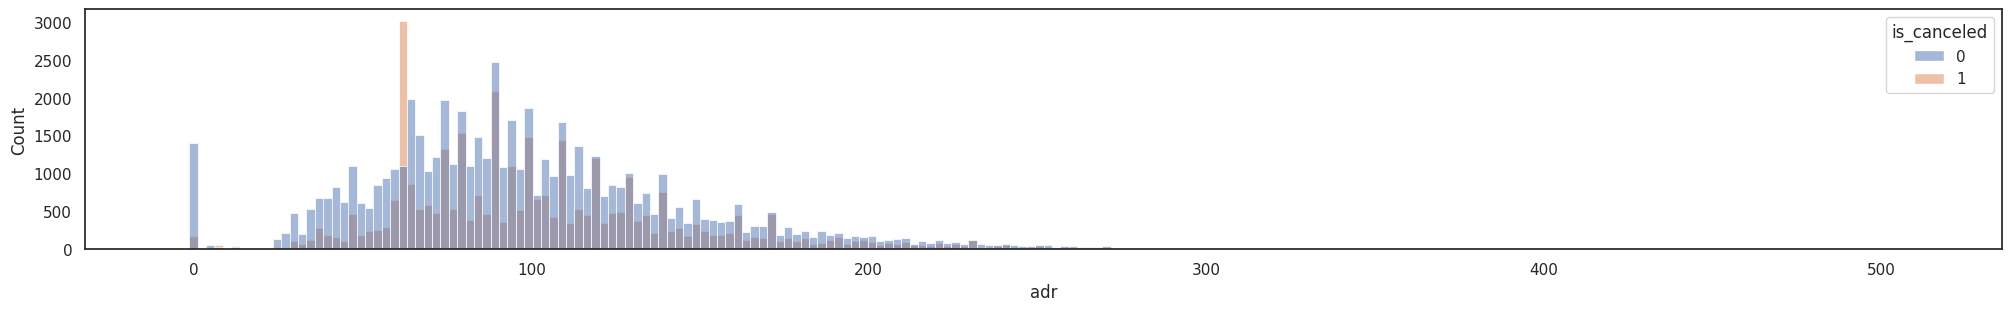

In [97]:
# adr

hist_vs_target('adr')

# 訓練データのマイナス値を含め、外れ値処理が必要
# キャンセル率が高い特定の価格が一定間隔で複数みられる

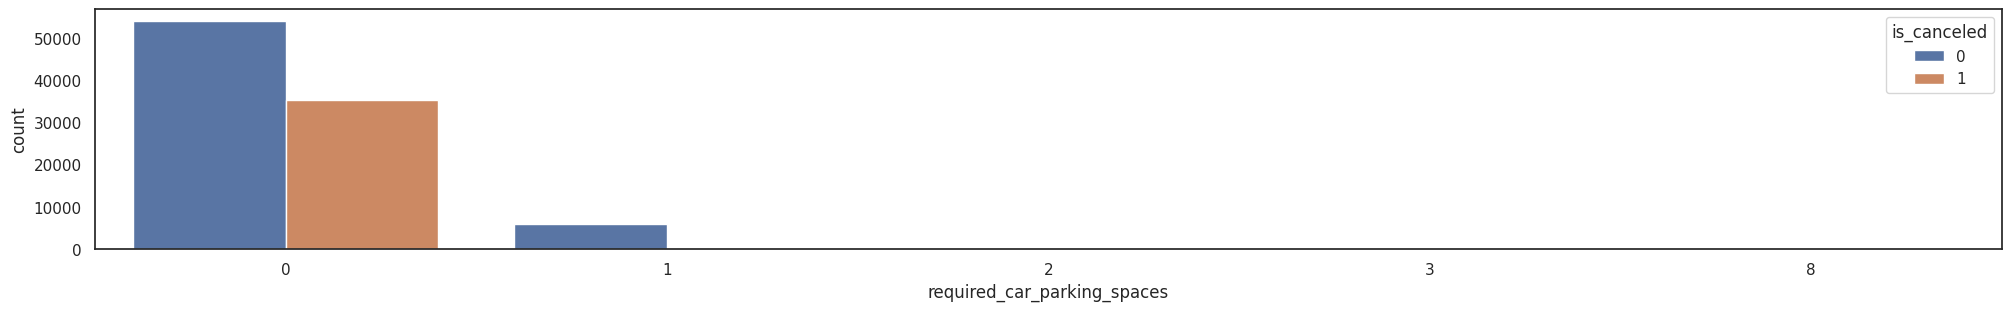

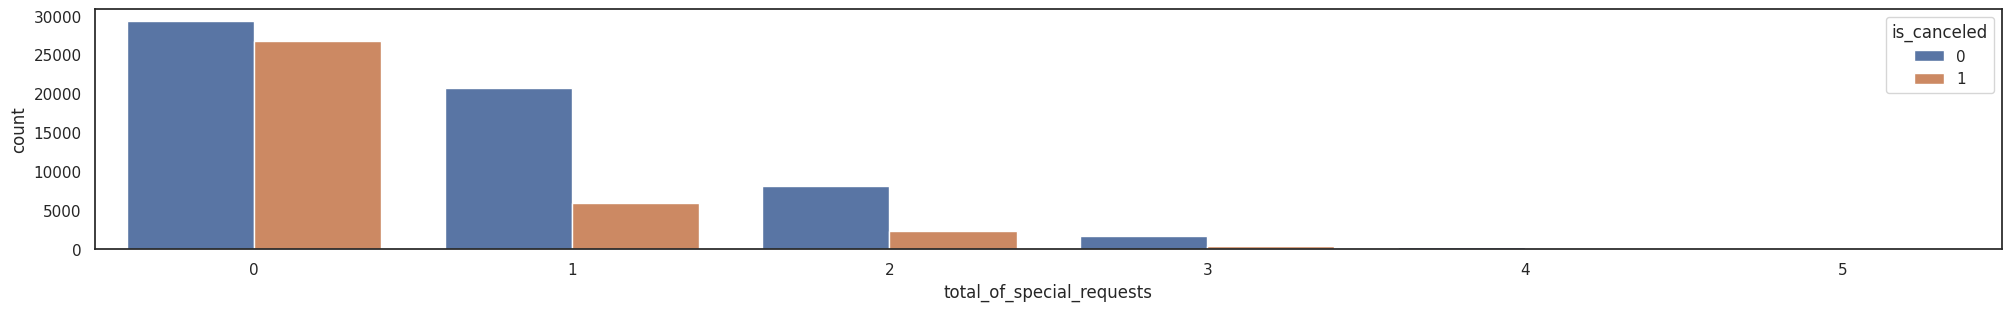

In [98]:
# required_cat_parking_spaces, total_of_special_requests

count_vs_target('required_car_parking_spaces')
count_vs_target('total_of_special_requests')

# なんらかの要求があるものほどキャンセル率が低い傾向がある
# 類似特徴量として扱う

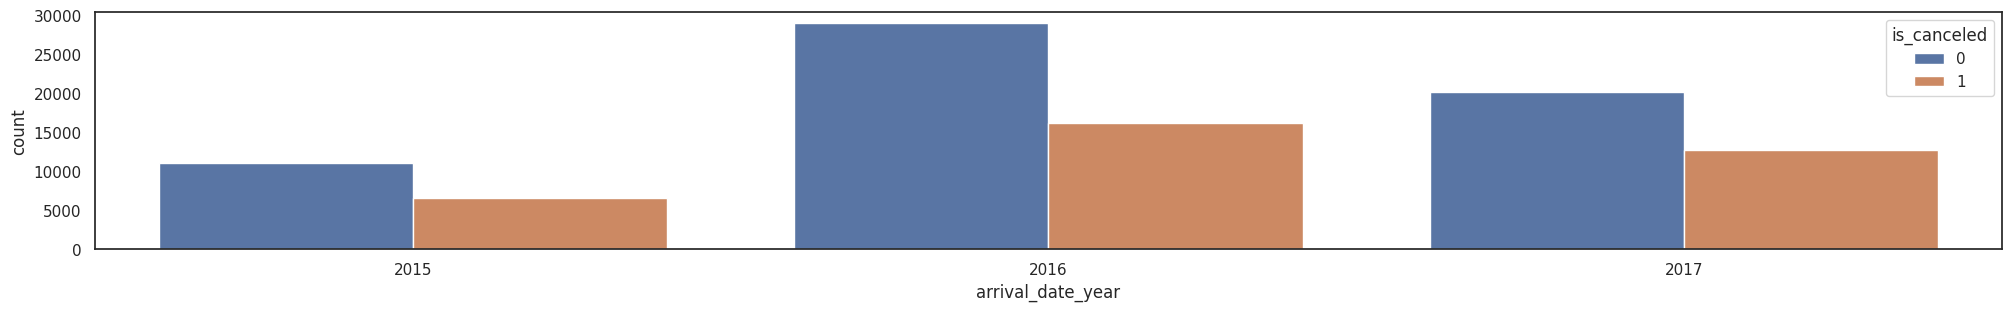

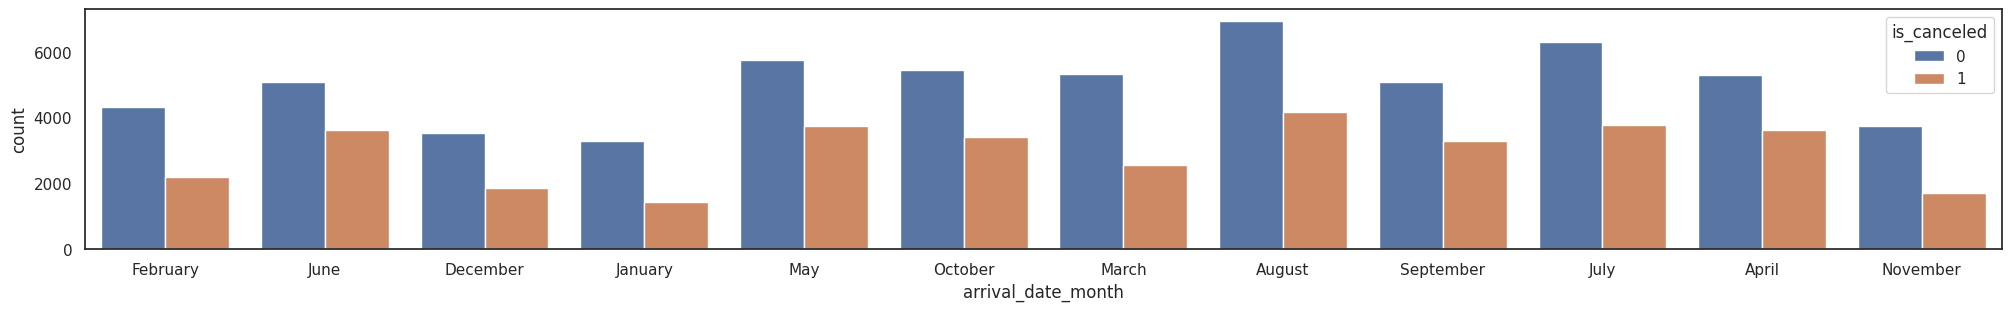

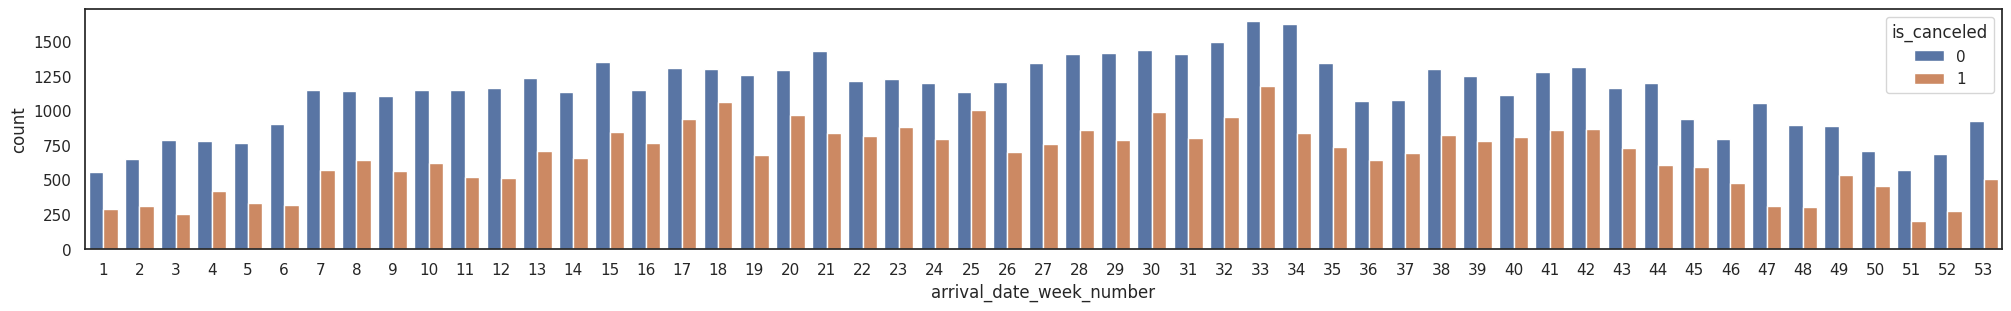

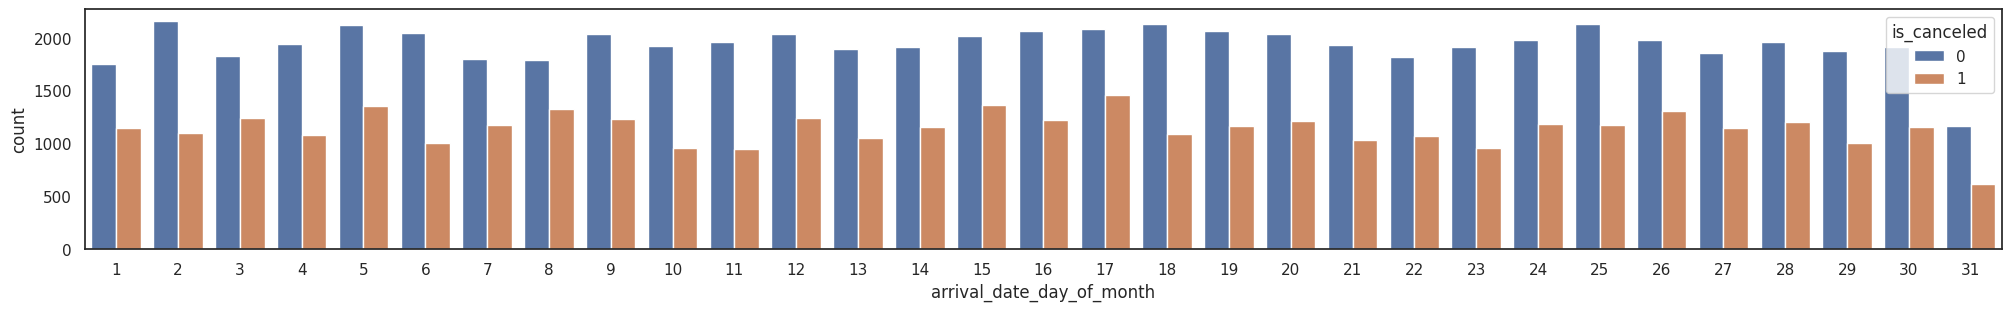

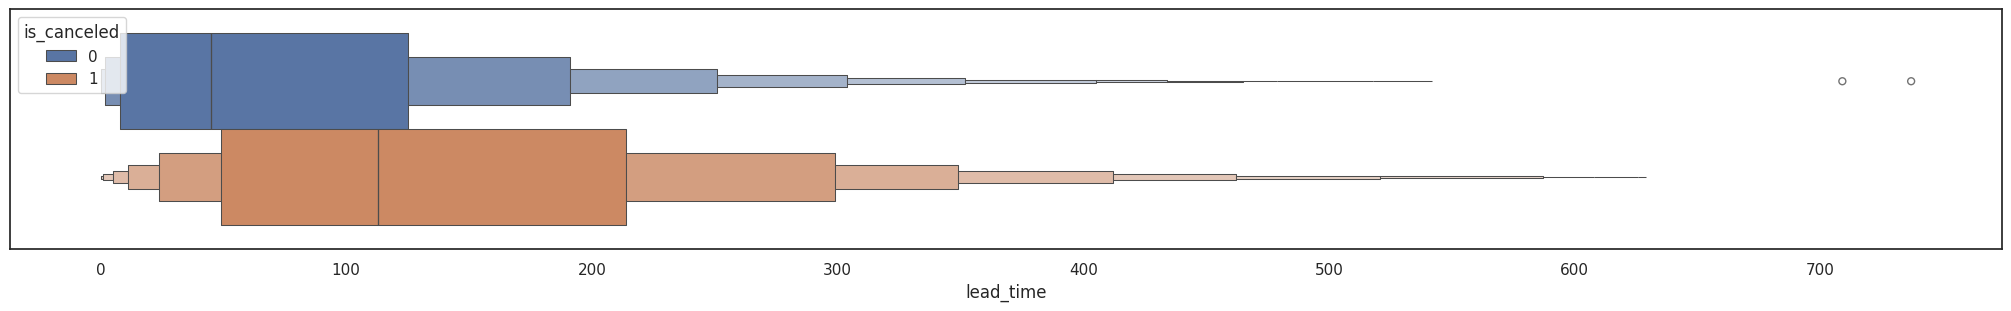

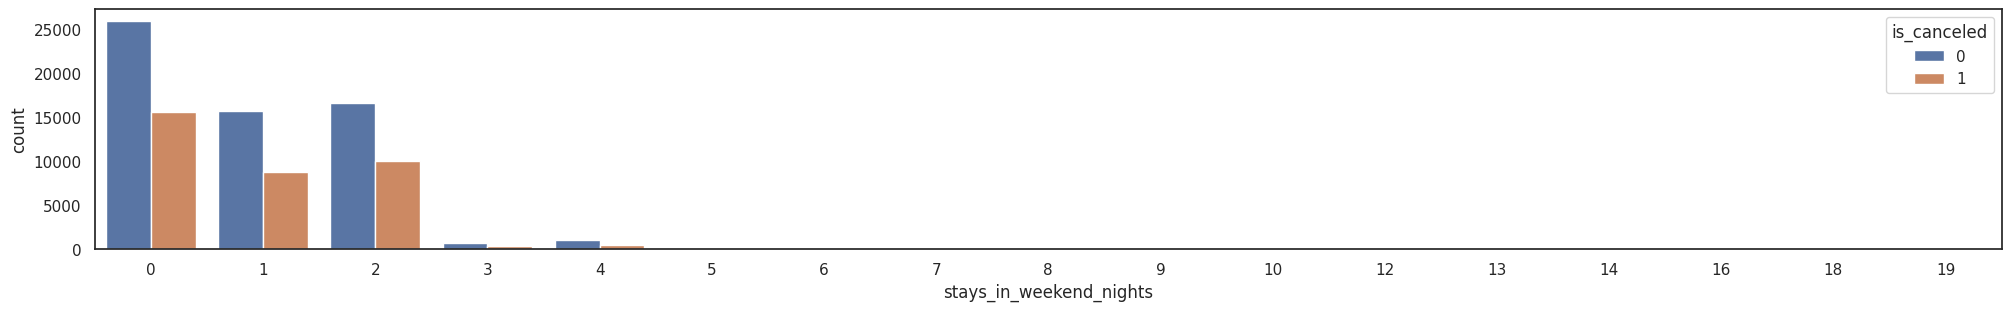

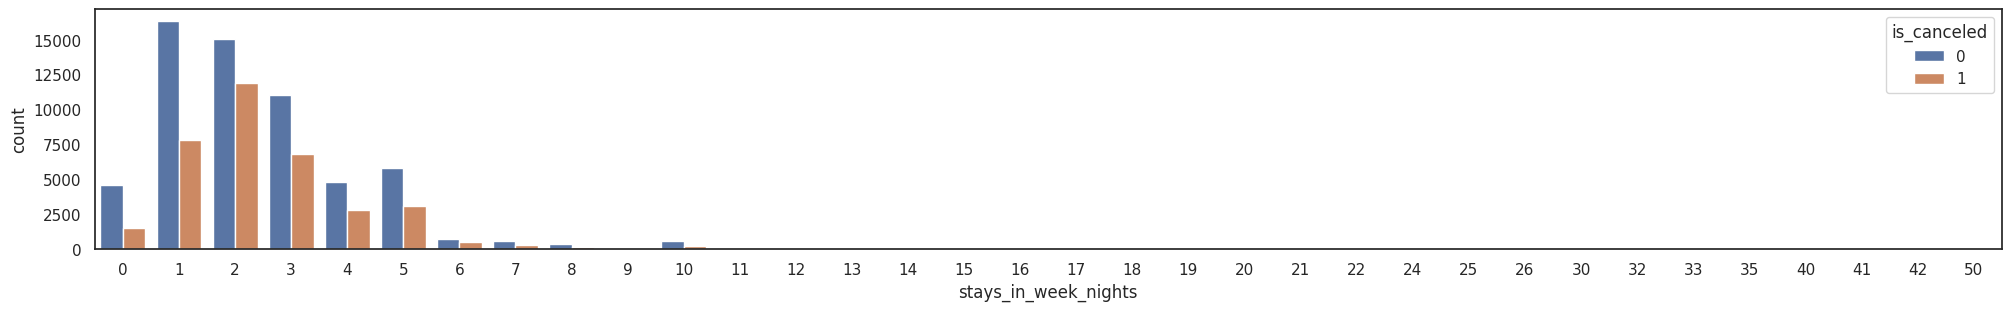

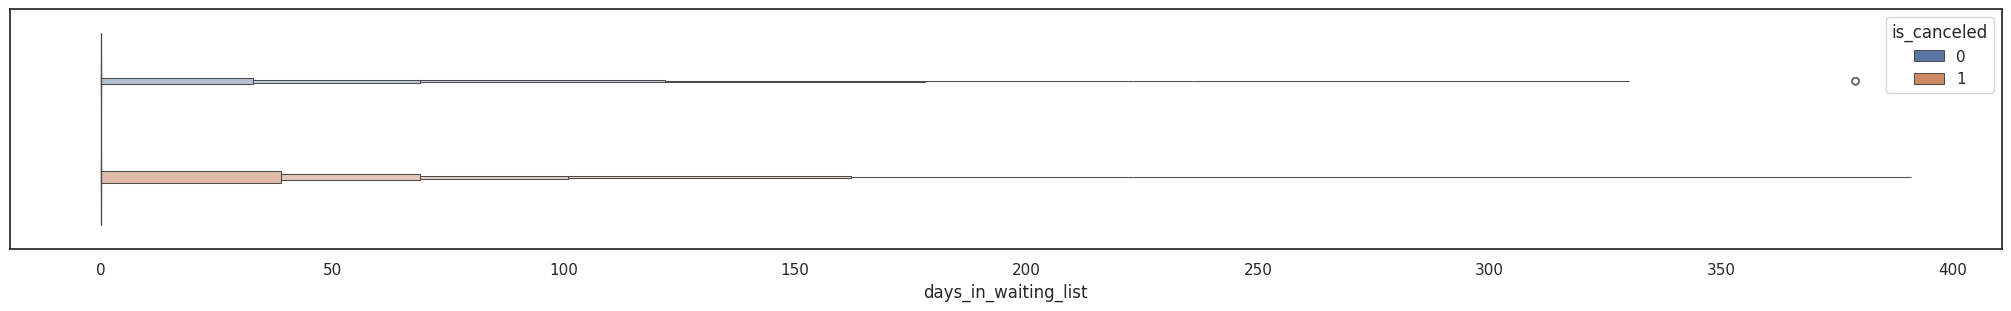

In [99]:
# 日次関係特徴量　arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month,
#                lead_time, stays_in_weekend_nights, stays_in_week_nights, days_in_waiting_list

count_vs_target('arrival_date_year')
count_vs_target('arrival_date_month')
count_vs_target('arrival_date_week_number')
count_vs_target('arrival_date_day_of_month')
boxen_vs_target('lead_time')
count_vs_target('stays_in_weekend_nights')
count_vs_target('stays_in_week_nights')
boxen_vs_target('days_in_waiting_list')

# 年、月、日からarrival_date、また、各々の期間からbooking_date, confirm_date, check_out_dateが推定できる、要整理

## 前処理、特徴量エンジニアリング

In [100]:
# mode_select（テスト環境と本番環境を切り替え）

test_flag = 1     # 0: submit
                  # 1: test
test_size = 0.1

if test_flag == 1:
    X, X_test, y, y_test = train_test_split(X, y, stratify=y, 
                                            test_size=test_size, random_state=0)
else:
    X_test = df_test.drop(columns=['ID'])
    y_test = 0

# バリデーションとは別にテストデータを分離して検証するテストモードを設定

In [101]:
# ハイパラ最適化済LGBMClassifierモデル（Hyperoptで最適化）

lgb_params =  {
  'colsample_bytree': 0.5045075565973658,
  'learning_rate': 0.09718299688781959,
  'max_depth': 24,
  'min_child_samples': 81,
  'n_estimators': 458,
  'num_leaves': 135,
  'reg_alpha': 0.14326289609895326,
  'reg_lambda': 0.9410709606671751,
  'subsample': 0.9828763412269045,
  'min_child_weight': 0.001,
  'subsample_freq': 5,
  'max_bin': 1024,
  'verbose': -1 
  }

lgb_model = LGBMClassifier(**lgb_params, random_state=2)

# kaggleではboosting='dart'が使用されているらしいと知ったが、遅い上、それ用の特徴量エンジニアリングが必要と分かり今回は断念
# デフォルトに近い特徴量ではdartの方が明らかに精度が高いが、作りこんだ状態ではboosting='gbdt'のデフォルトモデルの方が精度が出る

In [102]:
# Adversarial Validation 関数

def adversarial_validation(train_df, test_df):
    
    train_data = train_df.copy()
    test_data = test_df.copy()
    
    # 数値でないカテゴリを暫定数値化    
    le = LabelEncoder()
    for col in train_df.columns:
        if train_df[col].dtype == 'object':
            train_data[col] = le.fit_transform(train_data[col].astype(str))
            test_data[col] = le.transform(test_data[col].astype(str))
        elif train_df[col].dtype == 'datetime64[ns]':
            train_data.drop(col, axis=1, inplace=True)
            test_data.drop(col, axis=1, inplace=True)

    train_data['is_test'] = 0
    test_data['is_test'] = 1   
    combined = pd.concat([train_data, test_data], axis=0)
    
    XX = combined.drop('is_test', axis=1)
    yy = combined['is_test']
    XX_train, XX_valid, yy_train, yy_valid = train_test_split(XX, yy, test_size=0.5, random_state=42)
    
    clf = RandomForestClassifier(n_estimators=50, random_state=42)
    clf.fit(XX_train, yy_train)   
    preds = clf.predict_proba(XX_valid)[:, 1]
    score = roc_auc_score(yy_valid, preds)

    return score

# テストデータの分布異常検知用に導入

In [103]:
# custom_validation関数（途中検証用）

def custom_cross_val_score(model, X, y, cv=5, scoring='f1'):

    train_data = X.copy()

    # 非数値カテゴリを暫定数値化    
    le = LabelEncoder()
    for col in train_data.columns:
        if train_data[col].dtype == 'object':
            train_data[col] = le.fit_transform(train_data[col].astype(str))
    
        # datetime64[ns]を暫定削除
        elif train_data[col].dtype == 'datetime64[ns]':
            train_data.drop(col, axis=1, inplace=True)
    
    score = cross_val_score(model, train_data, y, cv=cv, scoring=scoring)
    return np.mean(score)


In [104]:
# 欠損値補完

for data in [X, X_test]:

    data['children'].fillna(0, inplace=True)
    data['country'].fillna('UKN', inplace=True)
    data['company'].fillna(0, inplace=True)
    data['agent'].fillna(0, inplace=True)

# childrenは多数の0、countryは別要素のUKNで補完
# companyとagentの欠損はそもそも該当がない可能性が高いので0で補完

In [105]:
# 少数カテゴリothers変換関数

def harmonize_categories(train_df, test_df, train_threshold):

    test_threshold = int(train_threshold / 4)

    for col in train_df.select_dtypes(include=['object', 'category']).columns:

        train_counts = train_df[col].value_counts()
        test_counts = test_df[col].value_counts()
        train_small_categories = train_counts[train_counts <= train_threshold].index
        test_small_categories = test_counts[test_counts <= test_threshold].index

        train_df[col] = train_df[col].replace(train_small_categories, 'others')
        test_df[col] = test_df[col].replace(test_small_categories, 'others')
    
    for col in [col for col in X.columns if X[col].dtype == 'object']:

        # カテゴリ変数のXにのみ存在する要素を'others' に置き換え
        replace_with_others = set(train_df[col]) - set(test_df[col])
        train_df[col] = train_df[col].apply(lambda x: 'others' if x in replace_with_others else x)
        # カテゴリ変数のX_testにのみ存在する要素を'others' に置き換え
        replace_with_others = set(test_df[col]) - set(train_df[col])
        test_df[col] = test_df[col].apply(lambda x: 'others' if x in replace_with_others else x)

    return train_df, test_df

# clipping関数

def clip_numeric(train_df, test_df, p=[1, 99], target='is_canceled'):

    num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [col for col in num_cols if col != target]

    for col in num_cols:
        lowerbound, upperbound = np.percentile(train_df[col], p)
        train_df[col] = np.clip(train_df[col], lowerbound, upperbound)
        test_df[col] = np.clip(test_df[col], lowerbound, upperbound)

    return train_df, test_df


In [106]:
# others変換、クリッピング

X, X_test = harmonize_categories(X, X_test, 50)
X, X_test = clip_numeric(X, X_test)

# countryに少数要素が多くノイズが気になるので他のカテゴリ変数とともに丸め処理
# 同様に数値も1%,99%水準のクリッピングで外れ値を処理

In [107]:

display(X.describe(include='object'))
display(X_test.describe(include='object'))
display(X.describe(exclude='object'))
display(X_test.describe(exclude='object'))

# 分布を目視確認

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type
count,85960,85960,85960,85960,85960,85960,85960,85960,85960,85960
unique,2,12,5,36,8,5,9,11,3,4
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient
freq,57056,10019,66437,34844,40701,70499,61995,53350,75347,64565


,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type
count,9552,9552,9552,9552,9552,9552,9552,9552,9552,9552
unique,2,12,5,36,7,5,9,11,3,4
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient
freq,6299,1113,7400,3961,4489,7810,6863,5885,8354,7153


,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.0,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000
mean,103.586854,2016.160831,27.129374,15.804502,0.919870,2.480026,1.856317,0.103839,0.0,0.031840,0.053944,0.059283,74.484423,10.044381,1.586191,101.336562,0.062227,0.568195
std,104.675134,0.707798,13.581706,8.776529,0.957878,1.760605,0.476661,0.395403,0.0,0.175576,0.225908,0.372540,105.137162,48.357520,9.684648,46.936688,0.241568,0.778707
min,0.000000,2015.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,69.000000,0.000000,0.000000
50%,70.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,94.500000,0.000000,0.000000
75%,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,154.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,447.000000,2017.000000,53.000000,31.000000,4.000000,10.000000,3.000000,2.000000,0.0,1.000000,1.000000,3.000000,385.000000,331.000000,75.000000,251.771000,1.000000,3.000000


,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.0,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000
mean,102.028057,2016.152952,27.081868,15.581449,0.914678,2.471001,1.849037,0.105318,0.0,0.032559,0.056637,0.063233,74.461369,9.817735,1.547843,101.109412,0.060825,0.565431
std,104.561480,0.712861,13.666289,8.797080,0.954491,1.749163,0.481063,0.395775,0.0,0.177488,0.231160,0.388804,104.990744,47.325831,9.632739,46.507027,0.239021,0.778810
min,0.000000,2015.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,69.000000,0.000000,0.000000
50%,68.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,94.000000,0.000000,0.000000
75%,159.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,155.000000,0.000000,0.000000,125.100000,0.000000,1.000000
max,447.000000,2017.000000,53.000000,31.000000,4.000000,10.000000,3.000000,2.000000,0.0,1.000000,1.000000,3.000000,385.000000,331.000000,75.000000,251.771000,1.000000,3.000000


In [108]:
adversarial_validation(X, X_test)

# ROC_AUC=0.5近辺であることを確認

0.49092966809042005

In [109]:
custom_cross_val_score(lgb_model, X, y, cv=5, scoring='f1')

# LGBMのハイパラ最適化と基本的な前処理のみでcv=5 0.85台が出る
# 同じ設定でもtest_modeでデータ数が減るほど精度は落ちる

0.848538986137586

### 時系列特徴量（時系列関連の特徴量が多くここを念入りに生成）

In [110]:
# 特徴量 arrival_date, booking_date, confirm_date, check_out_date,
#        total_nights

for data in [X, X_test]:

    data['arrival_date'] = pd.to_datetime(data['arrival_date_year'].astype(str) + '-' +
                                          data['arrival_date_month'].astype(str) + '-' +
                                          data['arrival_date_day_of_month'].astype(str))

    data['confirm_date'] = data['arrival_date'] - pd.to_timedelta(data['lead_time'], unit='D')
    data['booking_date'] = data['confirm_date'] - pd.to_timedelta(data['days_in_waiting_list'], unit='D')
    data['total_nights'] = data['stays_in_weekend_nights'] + data['stays_in_week_nights']
    data['check_out_date'] = data['arrival_date'] + pd.to_timedelta(data['total_nights'], unit='D')

X[['booking_date', 'confirm_date', 'arrival_date', 'check_out_date', 'days_in_waiting_list',
    'lead_time', 'total_nights']].head()

# 年、月、日からarrival_date、それをベースに各期間特徴量から計4つの日付を生成

,booking_date,confirm_date,arrival_date,check_out_date,days_in_waiting_list,lead_time,total_nights
3468,2016-11-28,2016-11-28,2016-11-28,2016-11-29,0,0,1
46545,2017-02-23,2017-02-23,2017-03-02,2017-03-06,0,7,4
66166,2016-03-01,2016-03-01,2016-03-01,2016-03-02,0,0,1
12536,2016-04-22,2016-04-22,2016-10-28,2016-10-31,0,189,3
58574,2017-01-25,2017-01-25,2017-01-27,2017-01-27,0,2,0


In [111]:
# 日付関連特徴量

reference_date = pd.Timestamp('2013-01-01')

def month_to_season(month):
    if month in [3, 4, 5]:
        return 1  # 春
    elif month in [6, 7, 8]:
        return 2  # 夏
    elif month in [9, 10, 11]:
        return 3  # 秋
    else:
        return 4  # 冬

for data in [X, X_test]:

    for col in ['arrival_date', 'booking_date', 'confirm_date', 'check_out_date']:
    
        # 日付成分
        data[f'{col}_year'] = data[col].dt.year
        data[f'{col}_season'] = data[col].apply(lambda x: month_to_season(x.month))
        data[f'{col}_month'] = data[col].dt.month
        data[f'{col}_day'] = data[col].dt.day
        data[f'{col}_weekday'] = data[col].dt.weekday

        # 経過日数
        data[f'{col}_days_since_reference'] = (data[col] - reference_date).dt.days

        # サイクリック特徴量
        # (週)
        data[f'{col}_day_of_week_sin'] = np.sin(data[col].dt.dayofweek * (2. * np.pi / 7))
        data[f'{col}_day_of_week_cos'] = np.cos(data[col].dt.dayofweek * (2. * np.pi / 7))
        # (月)
        data[f'{col}_month_sin'] = np.sin(data[col].dt.month * (2. * np.pi / 12))
        data[f'{col}_month_cos'] = np.cos(data[col].dt.month * (2. * np.pi / 12))
        # (季節)
        season = data[col].dt.month.apply(month_to_season)
        data[f'{col}_season_sin'] = np.sin(season * (2. * np.pi / 4))
        data[f'{col}_season_cos'] = np.cos(season * (2. * np.pi / 4))


# 作成した日付から日付関連特徴量を生成

None

<Axes: xlabel='arrival_date_week_number', ylabel='week_avg_adr'>

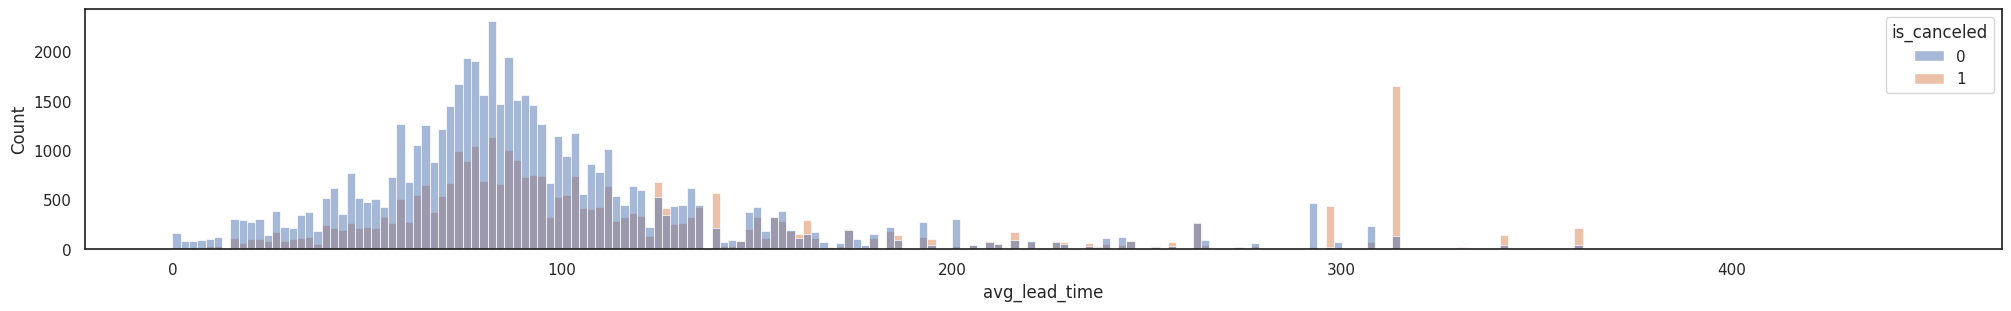

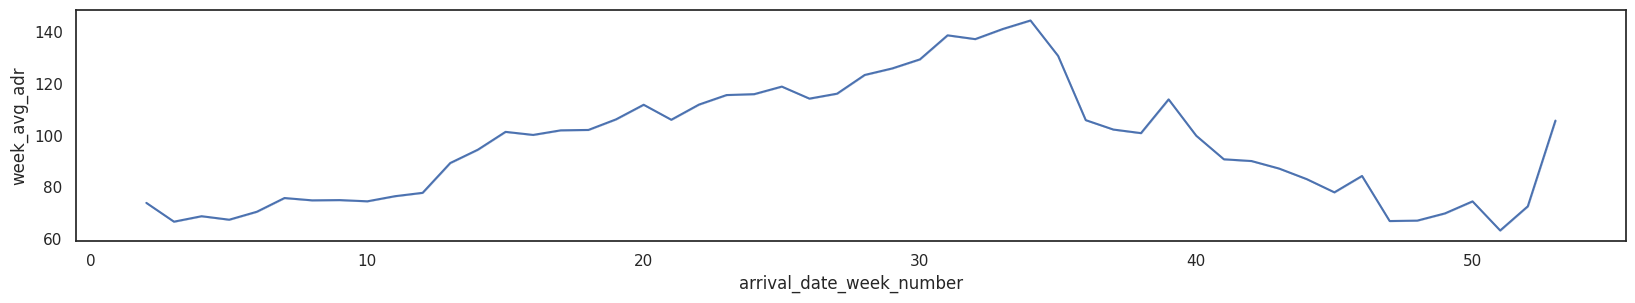

In [112]:
# 平均term week平均adr

avg_stay_nights = X.groupby('arrival_date')['total_nights'].mean()
avg_lead_time = X.groupby('confirm_date')['lead_time'].mean()
avg_days_in_waiting_list = X.groupby('booking_date')['days_in_waiting_list'].mean()

week_avg_adr = X.groupby('arrival_date_week_number')['adr'].mean()

for data in [X, X_test]:
    data['avg_stay_nights'] = data['arrival_date'].map(avg_stay_nights).fillna(0)
    data['avg_lead_time'] = data['confirm_date'].map(avg_lead_time).fillna(0)
    data['avg_days_in_waiting_list'] = data['booking_date'].map(avg_days_in_waiting_list).fillna(0)

    data['week_avg_adr'] = data['arrival_date_week_number'].map(week_avg_adr).fillna(0)

display(hist_vs_target('avg_lead_time'))

fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=X, x='arrival_date_week_number', y='week_avg_adr')

# avg_lead_timeにキャンセル率の大きなスパイクがみられる
# arrival_date_week_numberの使いどころとして年間のadr推移に着目(夏場のシーズンにかけ価格は上昇)

In [113]:
# 特徴量 weekend_weekday_ratio

def calculate_weekend_percentage(arrival_date, check_out_date):

    weekend_count = 0
    total_days = (check_out_date - arrival_date).days + 1
    for single_date in (arrival_date + timedelta(n) for n in range(total_days)):
        if single_date.weekday() in [4, 5, 6]:  # 金曜日、土曜日、日曜日
            weekend_count += 1

    weekend_percentage = (weekend_count / total_days) * 100
    return weekend_percentage

for data in [X, X_test]:
    data['weekend_weekday_ratio'] = data.apply(lambda x: calculate_weekend_percentage(x['arrival_date'], x['check_out_date']), axis=1)

# 週末は土日だけでなく金曜日の夜から

In [114]:
custom_cross_val_score(lgb_model, X, y, cv=5, scoring='f1')

0.8536845462037663

### その他の特徴量

In [115]:
# nmf変換特徴量生成関数

def transform_nmf(before_features_names, after_feature_name, train_df=X, test_df=X_test):
    nmf = NMF(n_components=1, init='nndsvda', random_state=2)

    # 数値でないカテゴリを数値化    
    le = LabelEncoder()
    for col in before_features_names:
        if train_df[col].dtype == 'object':
            train_df[col] = le.fit_transform(train_df[col].astype(str))
            test_df[col] = le.transform(test_df[col].astype(str))

    train_nmf = nmf.fit_transform(train_df[before_features_names])
    train_df[after_feature_name] = train_nmf.ravel()

    test_nmf = nmf.transform(test_df[before_features_names])
    test_df[after_feature_name] = test_nmf.ravel()

    return train_df, test_df

# 次元縮約はNMFで実施

In [116]:
# 特徴量　market_segment_distribution_channel_nmf

nmf_features = [
  ('market_segment', 'distribution_channel'),
  ('hotel', 'agent'),
  ('hotel', 'company')
]

for features in nmf_features:
    X, X_test = transform_nmf(list(features), '_'.join(features) + '_nmf')

# 組み合わせることに意味のありそうなペアを合成

In [117]:
# 特徴量 room_changed, all_requests, total_previous_cancellations, total_guests 

for data in [X, X_test]:
    data['room_changed'] = (data['reserved_room_type'] != data['assigned_room_type']).astype(int)
    data['all_requests'] = data['required_car_parking_spaces'] + data['total_of_special_requests']
    data['total_previous_cancellations'] = data['previous_cancellations'] - data['previous_bookings_not_canceled']
    data['total_guests'] = data['adults'] + data['children'] + data['babies']

display(vs_target('room_changed'))
display(vs_target('all_requests'))
vs_target('total_previous_cancellations')

# room_changeはキャンセルされずにarrivalがあって初めて実施される
# その他の類似特徴量を合成


,sum,count,mean
room_changed,,,
0,31269,75186,0.415889
1,572,10774,0.053091


,sum,count,mean
all_requests,,,
0,24115,48327,0.498996
1,5332,24230,0.220058
2,2057,10470,0.196466
3,337,2711,0.124308
4,0,222,0.000000


,sum,count,mean
total_previous_cancellations,,,
-3,13,682,0.019062
-2,56,745,0.075168
-1,45,1099,0.040946
0,27569,79258,0.347839
1,4158,4176,0.995690


In [118]:
# 特徴量 category_avg_stay_nights

cat_cols = [
    'hotel', 
    'meal', 
    'reserved_room_type', 
    'customer_type',
    'total_guests',
    'country'
]

for col in cat_cols:
    avg_stay_nights = X.groupby(col)['total_nights'].mean()

    for data in [X, X_test]:
        data[f'{col}_avg_stay_nights'] = data[col].map(avg_stay_nights).fillna(0)

# 平均宿泊日数をカテゴリ要素の説明特徴量として追加

In [119]:
# 特徴量 category_frequency

def frequency_encoding(train_df, test_df, column):

    freq_encoding = np.log(train_df[column].value_counts(normalize=True) + 1).to_dict()
    train_df[column + '_freq'] = train_df[column].map(freq_encoding)
    test_df[column + '_freq'] = test_df[column].map(freq_encoding)

    return train_df, test_df

cat_cols = [
    'hotel', 
    'meal', 
    'country', 
    'reserved_room_type', 
    'deposit_type',
    'customer_type',
    'total_previous_cancellations', 
    'all_requests',
]

for col in cat_cols:
    X, X_test = frequency_encoding(X, X_test, col)

# カテゴリの出現頻度を追加（スコア貢献するものだけ）

In [120]:
# 特徴量 category_集約統計量

agg_cols = ['min', 'max', 'mean', 'std']
cat_cols = ['agent', 'country', 'company']
num_cols = ['adr','days_in_waiting_list', 'lead_time']

for col in cat_cols:
    grp_df = X.groupby(col)[num_cols].agg(agg_cols)
    grp_df.columns = [f'{col}_' + '_'.join(c) for c in grp_df.columns]
    
    X = X.merge(grp_df, on=col, how='left').fillna(0) 
    X_test = X_test.merge(grp_df, on=col, how='left').fillna(0)

# 要素数の多いcountryおよびagent, companyをカテゴリ変数とみなして集約統計量特徴量を生成

In [121]:
# 特徴量 numeric_四則演算
num_cols = [
    ['total_nights', 'avg_stay_nights'], 
    ['lead_time', 'avg_lead_time'],
    ['days_in_waiting_list', 'avg_days_in_waiting_list'],
]
for data in [X, X_test]:
    for pair in num_cols:
        data[f'{pair[0]}_x_{pair[1]}'] = data[pair[0]] * data[pair[1]]  # 積
        data[f'{pair[0]}_div_{pair[1]}'] = data[pair[0]] / (data[pair[1]] + 0.1)  # 商
        data[f'{pair[0]}_minus_{pair[1]}'] = data[pair[0]] - data[pair[1]]  # 差

# 計算に意味のありそうなところだけピックアップして追加

In [122]:
# 特徴量削除

X.drop(columns=[
    'arrival_date', 'booking_date', 'confirm_date', 'check_out_date', 'assigned_room_type',
    'market_segment', 'distribution_channel',
    'babies', 'children', 'adults',
    ], inplace=True)

X_test.drop(columns=[
    'arrival_date', 'booking_date', 'confirm_date', 'check_out_date', 'assigned_room_type',
    'market_segment', 'distribution_channel',
    'babies', 'children', 'adults',
    ], inplace=True)

# 日付および統合特徴量を作成したもののうち消せるものを削除

In [123]:
display(X.describe(include='object'))
display(X.describe(exclude='object'))
display(X_test.describe(include='object'))
display(X_test.describe(exclude='object'))

,meal,country,reserved_room_type,deposit_type,customer_type
count,85960,85960,85960,85960,85960
unique,5,36,9,3,4
top,BB,PRT,A,No Deposit,Transient
freq,66437,34844,61995,75347,64565


,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_season,arrival_date_day,arrival_date_weekday,arrival_date_days_since_reference,arrival_date_day_of_week_sin,arrival_date_day_of_week_cos,arrival_date_month_sin,arrival_date_month_cos,arrival_date_season_sin,arrival_date_season_cos,booking_date_year,booking_date_season,booking_date_month,booking_date_day,booking_date_weekday,booking_date_days_since_reference,booking_date_day_of_week_sin,booking_date_day_of_week_cos,booking_date_month_sin,booking_date_month_cos,booking_date_season_sin,booking_date_season_cos,confirm_date_year,confirm_date_season,confirm_date_month,confirm_date_day,confirm_date_weekday,confirm_date_days_since_reference,confirm_date_day_of_week_sin,confirm_date_day_of_week_cos,confirm_date_month_sin,confirm_date_month_cos,...,reserved_room_type_freq,deposit_type_freq,customer_type_freq,total_previous_cancellations_freq,all_requests_freq,agent_adr_min,agent_adr_max,agent_adr_mean,agent_adr_std,agent_days_in_waiting_list_min,agent_days_in_waiting_list_max,agent_days_in_waiting_list_mean,agent_days_in_waiting_list_std,agent_lead_time_min,agent_lead_time_max,agent_lead_time_mean,agent_lead_time_std,country_adr_min,country_adr_max,country_adr_mean,country_adr_std,country_days_in_waiting_list_min,country_days_in_waiting_list_max,country_days_in_waiting_list_mean,country_days_in_waiting_list_std,country_lead_time_min,country_lead_time_max,country_lead_time_mean,country_lead_time_std,company_adr_min,company_adr_max,company_adr_mean,company_adr_std,company_days_in_waiting_list_min,company_days_in_waiting_list_max,company_days_in_waiting_list_mean,company_days_in_waiting_list_std,company_lead_time_min,company_lead_time_max,company_lead_time_mean,company_lead_time_std,total_nights_x_avg_stay_nights,total_nights_div_avg_stay_nights,total_nights_minus_avg_stay_nights,lead_time_x_avg_lead_time,lead_time_div_avg_lead_time,lead_time_minus_avg_lead_time,days_in_waiting_list_x_avg_days_in_waiting_list,days_in_waiting_list_div_avg_days_in_waiting_list,days_in_waiting_list_minus_avg_days_in_waiting_list
count,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,8.596000e+04,85960.000000,8.596000e+04,8.596000e+04,85960.00000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,8.596000e+04,85960.000000,8.596000e+04,8.596000e+04,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,8.596000e+04,85960.000000,...,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.0,85960.000000,85960.000000,85960.000000,85960.0,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,85960.000000,8.596000e+04,85960.000000,85960.000000,8.596000e+04,85960.000000,85960.000000,8.596000e+04
mean,0.336249,103.586854,2016.160831,6.542671,27.129374,15.804502,0.919870,2.480026,0.031840,0.053944,0.059283,74.484423,10.044381,1.586191,101.336562,0.062227,0.568195,3.399895,2.309039,15.804502,2.995963,1336.962983,-0.017473,-0.058427,-5.374641e-02,-0.145034,3.795952e-02,-1.397976e-01,2015.91581,2.674139,6.047859,15.071778,

,meal,country,reserved_room_type,deposit_type,customer_type
count,9552,9552,9552,9552,9552
unique,5,36,9,3,4
top,BB,PRT,A,No Deposit,Transient
freq,7400,3961,6863,8354,7153


,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_season,arrival_date_day,arrival_date_weekday,arrival_date_days_since_reference,arrival_date_day_of_week_sin,arrival_date_day_of_week_cos,arrival_date_month_sin,arrival_date_month_cos,arrival_date_season_sin,arrival_date_season_cos,booking_date_year,booking_date_season,booking_date_month,booking_date_day,booking_date_weekday,booking_date_days_since_reference,booking_date_day_of_week_sin,booking_date_day_of_week_cos,booking_date_month_sin,booking_date_month_cos,booking_date_season_sin,booking_date_season_cos,confirm_date_year,confirm_date_season,confirm_date_month,confirm_date_day,confirm_date_weekday,confirm_date_days_since_reference,confirm_date_day_of_week_sin,confirm_date_day_of_week_cos,confirm_date_month_sin,confirm_date_month_cos,...,reserved_room_type_freq,deposit_type_freq,customer_type_freq,total_previous_cancellations_freq,all_requests_freq,agent_adr_min,agent_adr_max,agent_adr_mean,agent_adr_std,agent_days_in_waiting_list_min,agent_days_in_waiting_list_max,agent_days_in_waiting_list_mean,agent_days_in_waiting_list_std,agent_lead_time_min,agent_lead_time_max,agent_lead_time_mean,agent_lead_time_std,country_adr_min,country_adr_max,country_adr_mean,country_adr_std,country_days_in_waiting_list_min,country_days_in_waiting_list_max,country_days_in_waiting_list_mean,country_days_in_waiting_list_std,country_lead_time_min,country_lead_time_max,country_lead_time_mean,country_lead_time_std,company_adr_min,company_adr_max,company_adr_mean,company_adr_std,company_days_in_waiting_list_min,company_days_in_waiting_list_max,company_days_in_waiting_list_mean,company_days_in_waiting_list_std,company_lead_time_min,company_lead_time_max,company_lead_time_mean,company_lead_time_std,total_nights_x_avg_stay_nights,total_nights_div_avg_stay_nights,total_nights_minus_avg_stay_nights,lead_time_x_avg_lead_time,lead_time_div_avg_lead_time,lead_time_minus_avg_lead_time,days_in_waiting_list_x_avg_days_in_waiting_list,days_in_waiting_list_div_avg_days_in_waiting_list,days_in_waiting_list_minus_avg_days_in_waiting_list
count,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9.552000e+03,9552.000000,9.552000e+03,9.552000e+03,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9.552000e+03,9552.000000,9.552000e+03,9.552000e+03,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9.552000e+03,9552.000000,...,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.0,9552.000000,9552.000000,9552.000000,9552.0,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000
mean,0.340557,102.028057,2016.152952,6.538212,27.081868,15.581449,0.914678,2.471001,0.032559,0.056637,0.063233,74.461369,9.817735,1.547843,101.109412,0.060825,0.565431,3.385678,2.317420,15.581449,2.980946,1333.729481,-0.023056,-0.049378,-4.701223e-02,-0.140417,4.020101e-02,-1.335846e-01,2015.912165,2.672215,6.041876,14.952366,2.599351,1230.153580,0.117978,-0.033609,5.848164e-02,0.116741,-1.999581e-02,1.284548e-01,201

In [124]:
# ラベルエンコーディング
for col in [
    'hotel', 'meal', 'country',
    'reserved_room_type', 'deposit_type', 'customer_type',
    ]:

    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    X_test[col] = le.transform(X_test[col])

# GBDTなのでOne-Hot-Encodingは行わない

In [125]:
# lightgbm_under_sampling_cross_validation_mix関数

def lgbm_us_cv_mix(X, y, X_test, n, num_list):

    X_preds = []
    X_test_preds_avged = []

    for lgb_num in num_list:

        X_pred = pd.DataFrame(index=X.index)
        X_test_pred = pd.DataFrame(index=X_test.index)
        X_test_pred_avged = pd.DataFrame(index=X_test.index)

        for num in range(n):
            under = RandomUnderSampler(random_state=num)
            model = LGBMClassifier(**lgb_params, random_state=num + lgb_num)
            pipe = imblearn_pipeline(steps=[('under', under), ('model', model)])
        
            skf = StratifiedKFold(n_splits=2 + (num % 29), shuffle=True, random_state=2)
            for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
                X_train, X_val = X.iloc[train_idx, :], X.iloc[val_idx, :]
                y_train = y.iloc[train_idx] 
            
                pipe.fit(X_train, y_train)
                pred = pipe.predict_proba(X_val)[:, 1]
                test_pred = pipe.predict_proba(X_test)[:, 1]
                X_pred.loc[val_idx, f'lgb_{lgb_num}_p_{num}'] = pred
                X_test_pred.loc[:, f'p_{num}:{i}'] = test_pred
        X_preds.append(X_pred)

        # test_data averaging
        for num in range(n):
            cols = [col for col in X_test_pred.columns if col.startswith(f'p_{num}:')]
            X_test_pred_avged[f'lgb_{lgb_num}_p_{num}'] = X_test_pred[cols].mean(axis=1)
        X_test_preds_avged.append(X_test_pred_avged)

        score = cross_val_score(LogisticRegression(), X_pred, y, cv=10, scoring='f1')
        print(f'lgb_{lgb_num}\n  f1_avg_us_cv_score: {np.mean(score)}')
        print(f'  {score}\n')

    return X_preds, X_test_preds_avged


# 計算コストの低いLightGBMのみで大量アンサンブルを行う
# under_samplingをrandom_state_unsembleと組み合わせ、multi_cvも加えた


In [126]:
def rfc_us_cv_mix(X, y, X_test, n=30):

    X_pred = pd.DataFrame(index=X.index)
    X_test_pred = pd.DataFrame(index=X_test.index)
    X_test_pred_avged = pd.DataFrame(index=X_test.index)

    for num in range(n):
        under = RandomUnderSampler(random_state=num)
        model= RandomForestClassifier(n_estimators=500, random_state=num+3)
        pipe = imblearn_pipeline(steps=[('under', under), ('model', model)])
        
        skf = StratifiedKFold(n_splits=2 + (num % 29), shuffle=True, random_state=2)
        for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx, :], X.iloc[val_idx, :]
            y_train = y.iloc[train_idx] 
            
            pipe.fit(X_train, y_train)
            pred = pipe.predict_proba(X_val)[:, 1]
            test_pred = pipe.predict_proba(X_test)[:, 1]
            X_pred.loc[val_idx, f'rfc_p_{num}'] = pred
            X_test_pred.loc[:, f'rfc_p_{num}:{i}'] = test_pred

    # test_data averaging
    for num in range(n):
        cols = [col for col in X_test_pred.columns if col.startswith(f'rfc_p_{num}:')]
        X_test_pred_avged[f'rfc_p_{num}'] = X_test_pred[cols].mean(axis=1)

    score = cross_val_score(LogisticRegression(), X_pred, y, cv=10, scoring='f1')
    print(f'rfc_f1_avg_us_cv_score: {np.mean(score)}')
    print(f'  {score}\n')

    return X_pred, X_test_pred_avged

# us_cv_mix関数をlgbmバージョンとrfcバージョンに分離、独立させた

In [127]:
def plot_f1_curve(y_true, y_pred):

    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    f1_scores = [hmean([p, r]) if p+r > 0 else 0 for p, r in zip(precision, recall)]
    max_f1_index = np.argmax(f1_scores)
    p = thresholds[max_f1_index]
    pre = precision_score(y_true, np.where(y_pred >= p, 1, 0))
    rec = recall_score(y_true, np.where(y_pred >= p, 1, 0))
    f1 = f1_score(y_true, np.where(y_pred >= p, 1, 0))
    
    return precision, recall, thresholds, f1_scores, f1, pre, rec, max_f1_index, p


def f1_plots(y_true, y_pred, model_name):
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12), tight_layout=True)
    fig.suptitle(model_name)

    # 第1グラフ
    precision, recall, thresholds, f1_scores, f1, pre, rec, max_f1_index, p = plot_f1_curve(y_true, y_pred)
    sns.lineplot(x=thresholds, y=f1_scores[:-1], label='f1_score', ax=ax1)
    sns.lineplot(x=thresholds, y=recall[:-1], label='recall_score', ax=ax1)
    sns.lineplot(x=thresholds, y=precision[:-1], label='precision_score', ax=ax1)
    ax1.set_xlabel('threshold')
    ax1.set_title(f'f1: {f1:.5f}\nprecision: {pre:.3f}\nrecall: {rec:.3f}\nthreshold: {p:.3f}')
    ax1.legend()

    # 第2グラフ
    mat = confusion_matrix(y_true, np.where(y_pred >= p, 1, 0))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d',
        xticklabels=[1, 0], yticklabels=[1, 0],
            cmap='RdPu', cbar=False, ax=ax2)
    ax2.set_xlabel('True label')
    ax2.set_ylabel('Pred label')
    ax2.set_title('Confusion Matrix')

    # 第3グラフ
    y_predicted = np.where(y_pred >= p, 1, 0).flatten()
    correct_indices = np.where(y_true == y_predicted)[0]
    incorrect_indices = np.where(y_true != y_predicted)[0]

    ax3.hist(y_pred[correct_indices], bins=50, alpha=0.5, label="Correct")
    ax3.hist(y_pred[incorrect_indices], bins=50, alpha=0.5, label="Incorrect")
    ax3.set_xlabel("Predicted Probability")
    ax3.set_ylabel("Frequency")
    ax3.legend()
    ax3.set_title("Distribution of Predicted Probabilities")

    # 第4グラフ
    fp_indices = np.where((y_true == 0) & (y_pred > p))[0]
    fn_indices = np.where((y_true == 1) & (y_pred <= p))[0]

    ax4.hist(y_pred[fp_indices], bins=int((1-p)*100), alpha=0.5, label="False Positives", color='red')
    ax4.hist(y_pred[fn_indices], bins=int(p*100), alpha=0.5, label="False Negatives", color='blue')
    ax4.set_xlabel("Predicted Probability")
    ax4.set_ylabel("Frequency")
    ax4.legend()
    ax4.set_title("Distribution of FP and FN Predicted Probabilities")

    return p

# 4つの可視化
# コードはもう少し整理した方が良い

In [128]:
score = adversarial_validation(X, X_test)
print(f'Adversarial_Validation_score: {score}\n')

# 最終確認、分布異常なし

Adversarial_Validation_score: 0.4978154793370676



In [129]:
np.max(X_test.isnull().sum())

# エラーもないことを確認

0

In [130]:
len(X.columns)

# 特徴量数は140

140

In [131]:
np.mean(cross_val_score(lgb_model, X, y, cv=5, scoring='f1'))

# アンサンブル実施前のcv=5ベーススコア

0.8567405042137178

### モデルの学習、予測、評価

In [132]:
# learning

score = cross_val_score(lgb_model, X, y, cv=10, scoring='f1')
print(f'lgb_model\n  base_cv_score: {np.mean(score)}\n  {score}\n')

n = 10
num_list = [1, 3, 5, 9, 11, 13, 14, 33, 36, 45]

X_preds, X_test_preds = lgbm_us_cv_mix(X, y, X_test, n, num_list)
X_pred_rfc, X_test_pred_rfc = rfc_us_cv_mix(X, y, X_test, n=5)

# 本番モードは lgbm n=60, rfc n=30
# 但し、ローカル環境で20時間くらいかかる

# なお、テストモードの1割少ないデータで、n=10程度であっても0.74台のスコアになる
# これをそのまま本番モードにすればよさそうなものだがpublicスコアがおかしなことになるのでこの辺りの組み合わせを追求できなかった
# 少なくともバリデーションスコアはn値を増やせば改善傾向にあるのでpublicスコアと両立するところを探った結論がサブミット結果となっている

lgb_model
  base_cv_score: 0.8594404645434659
  [0.86256983 0.85321394 0.86098224 0.85508867 0.86389776 0.86055017
 0.85869046 0.86230032 0.85845909 0.85865215]

lgb_1
  f1_avg_us_cv_score: 0.862444895587639
  [0.86715465 0.85997522 0.86538762 0.85413114 0.8639477  0.86399505
 0.86361521 0.86317751 0.85944272 0.86362215]

lgb_3
  f1_avg_us_cv_score: 0.8620962905597869
  [0.86683261 0.85594666 0.86356541 0.85563817 0.86264761 0.86494829
 0.86108955 0.86546247 0.86130934 0.8635228 ]

lgb_5
  f1_avg_us_cv_score: 0.8622147095222331
  [0.86547711 0.85824822 0.86510903 0.85339506 0.86372839 0.86372064
 0.86254455 0.86624204 0.86014526 0.86353678]

lgb_9
  f1_avg_us_cv_score: 0.8618612723362695
  [0.86615887 0.85851245 0.86405494 0.85382831 0.86261086 0.86468953
 0.86072812 0.86638669 0.85900217 0.8626408 ]

lgb_11
  f1_avg_us_cv_score: 0.8627082828233043
  [0.86747362 0.8590895  0.86637527 0.85480383 0.86411692 0.86465584
 0.86210102 0.86380597 0.86010844 0.86455241]

lgb_13
  f1_avg_us_cv_s

In [133]:
X_preds.append(X_pred_rfc.values)
X_test_preds.append(X_test_pred_rfc.values)
num_list.append('rfc')

In [134]:
# level_1 stacking

l1_model = LogisticRegression()

l1_preds = pd.DataFrame(index=X.index)
l1_preds_test = pd.DataFrame(index=X_test.index)
ps = []
p_tests = []

for num, xx, xx_test in zip(num_list, X_preds, X_test_preds):

    l1_preds[f'lgb_{num}'] = cross_val_predict(l1_model, xx, y, cv=10, method='predict_proba')[:, 1]
    l1_model.fit(xx, y)
    l1_preds_test[f'lgb_{num}'] = l1_model.predict_proba(xx_test)[:, 1]

    _, _, _, _, _, _, _, _, p = plot_f1_curve(y, l1_preds[f'lgb_{num}'])
    l1_optimal_data = np.where(l1_preds[f'lgb_{num}'] > p, 1, 0)
    ps.append(p)
    print(f'lgb_{num}_validation_f1_score: {f1_score(y, l1_optimal_data)}')
    print(f'lgb_{num}_optimal_p: p={p}\n{pd.DataFrame(l1_optimal_data).value_counts(normalize=True)}\n')

    if test_flag == 1:
        _, _, _, _, _, _, _, _, p_test = plot_f1_curve(y_test, l1_preds_test[f'lgb_{num}'])
        l1_optimal_data_test = np.where(l1_preds_test[f'lgb_{num}'] > p_test, 1, 0)
        p_tests.append(p_test)
        print(f'lgb_{num}_test_f1_score:       {f1_score(y_test, l1_optimal_data_test)}')
        print(f'lgb_{num}_test_optimal_p: p={p_test}\n{pd.DataFrame(l1_optimal_data_test).value_counts(normalize=True)}\n')



lgb_1_validation_f1_score: 0.8628428927680797
lgb_1_optimal_p: p=0.5138680974959426
0    0.624023
1    0.375977
Name: proportion, dtype: float64

lgb_1_test_f1_score:       0.8723074757144869
lgb_1_test_optimal_p: p=0.5103974172459549
0    0.62678
1    0.37322
Name: proportion, dtype: float64

lgb_3_validation_f1_score: 0.8623521528416263
lgb_3_optimal_p: p=0.5141195914466741
0    0.623895
1    0.376105
Name: proportion, dtype: float64

lgb_3_test_f1_score:       0.873015873015873
lgb_3_test_optimal_p: p=0.5349869108738425
0    0.6317
1    0.3683
Name: proportion, dtype: float64

lgb_5_validation_f1_score: 0.8625356894822132
lgb_5_optimal_p: p=0.47571113557467326
0    0.616636
1    0.383364
Name: proportion, dtype: float64

lgb_5_test_f1_score:       0.8732553221485972
lgb_5_test_optimal_p: p=0.5125109036805289
0    0.627827
1    0.372173
Name: proportion, dtype: float64

lgb_9_validation_f1_score: 0.862241190023349
lgb_9_optimal_p: p=0.482856033798256
0    0.618078
1    0.381922
Name:

meta_pred_validation_f1_score: 0.8628197391021772
meta_pred_optimal_p: p=0.392816444312418
0    0.618637
1    0.381363
Name: proportion, dtype: float64



0.392816444312418

meta_pred_test_f1_score:       0.8739118225217636
meta_pred_test_optimal_p: p=0.42153368823127263
0    0.624791
1    0.375209
Name: proportion, dtype: float64



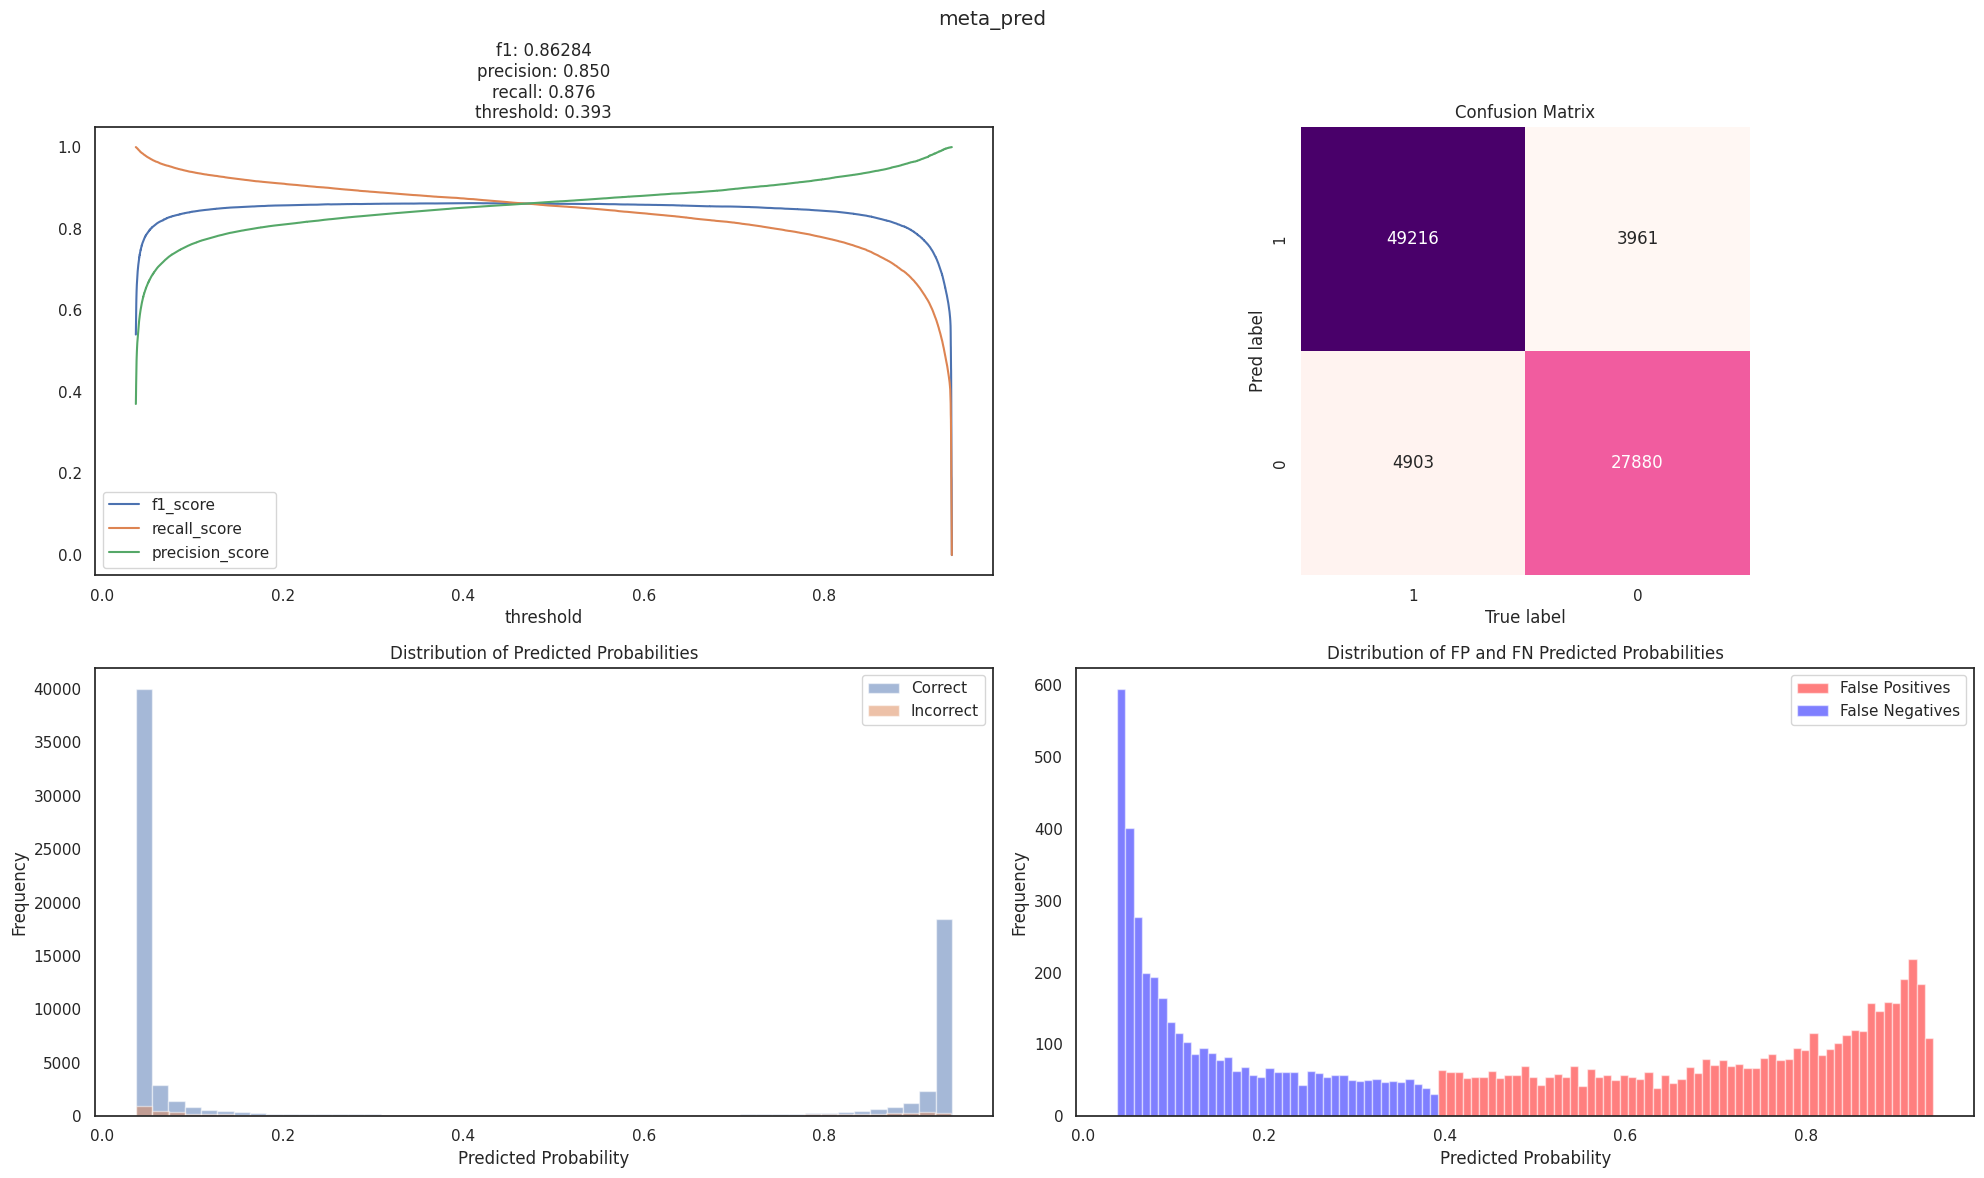

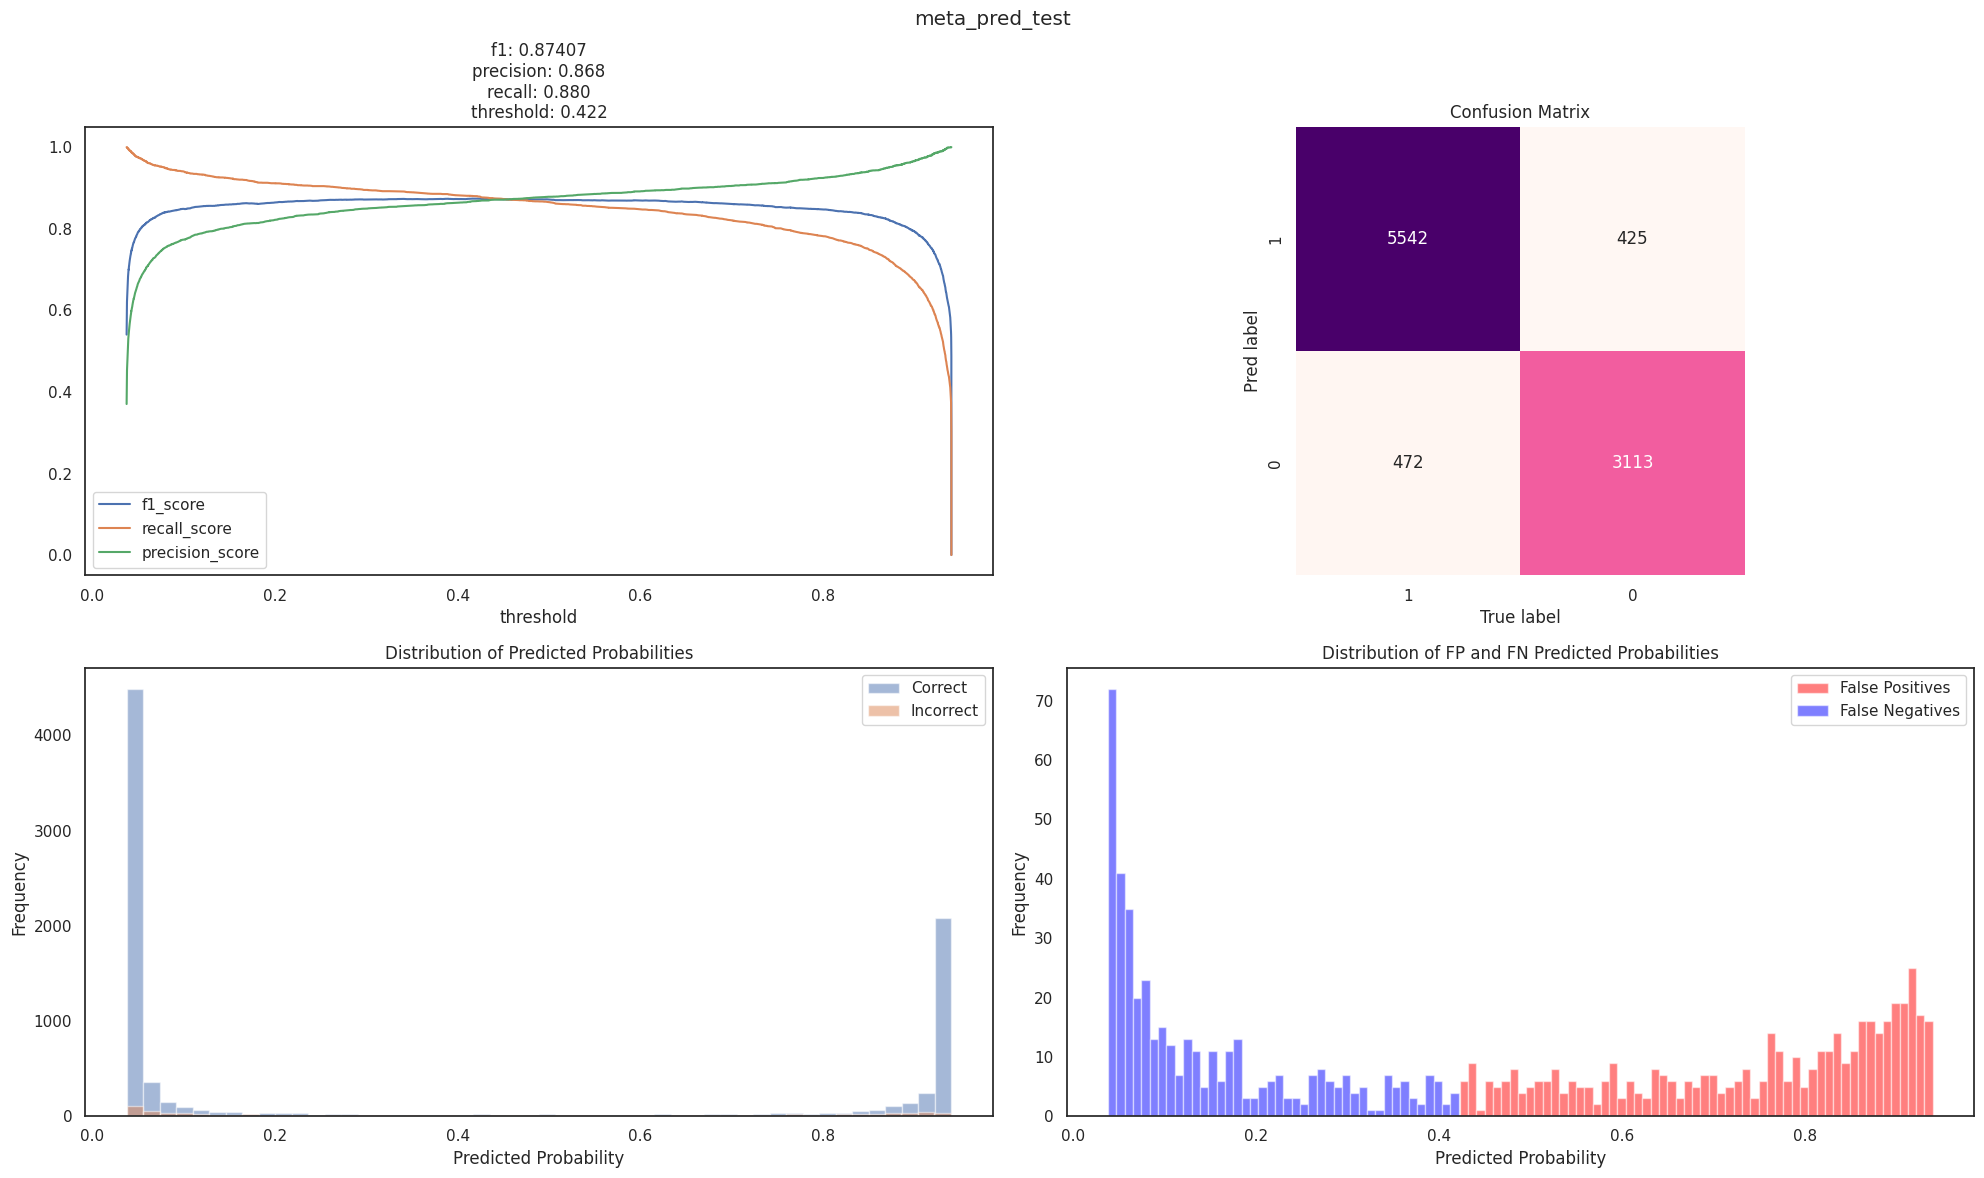

In [135]:
# level2_stacking

meta_model = LogisticRegression()

meta_pred = pd.DataFrame(index=X.index)
meta_pred_test = pd.DataFrame(index=X_test.index)

meta_pred = cross_val_predict(meta_model, l1_preds, y, cv=10, method='predict_proba')[:, 1]
meta_model.fit(l1_preds, y)
meta_pred_test = meta_model.predict_proba(l1_preds_test)[:, 1]

_, _, _, _, _, _, _, _, meta_p = plot_f1_curve(y, meta_pred)
optimal_data = np.where(meta_pred > meta_p, 1, 0)
print(f'meta_pred_validation_f1_score: {f1_score(y, optimal_data)}')
print(f'meta_pred_optimal_p: p={meta_p}\n{pd.DataFrame(optimal_data).value_counts(normalize=True)}\n')
display(f1_plots(y, meta_pred.ravel(), 'meta_pred'))

if test_flag == 1:

    _, _, _, _, _, _, _, _, meta_p_test = plot_f1_curve(y_test, meta_pred_test)
    optimal_data_test = np.where(meta_pred_test > meta_p_test, 1, 0)
    print(f'meta_pred_test_f1_score:       {f1_score(y_test, optimal_data_test)}')
    print(f'meta_pred_test_optimal_p: p={meta_p_test}\n{pd.DataFrame(optimal_data_test).value_counts(normalize=True)}\n')
    f1_plots(y_test, meta_pred_test.ravel(), 'meta_pred_test')

### Submission

In [136]:
print(f'val_data_optimal_threshold={meta_p}')

if test_flag == 1:
    print(f'test_data_optimal_threshold={meta_p_test}')

val_data_optimal_threshold=0.392816444312418
test_data_optimal_threshold=0.42153368823127263


In [137]:
# 提出データセット

df_submission = df_test[['ID']]
df_submission['prediction'] = None 
df_submission.set_index('ID', inplace=True) # 提出用ファイルフォーマット


p = meta_p # 初期値にバリデーション最適閾値を設定

if test_flag == 0:

    df_submission['prediction'] = np.where(meta_pred_test > p, 1, 0)

    print(df_submission.shape)
    df_submission.to_csv('submission.csv')

    display(df['is_canceled'].value_counts(normalize=True))
    display(df_submission['prediction'].value_counts(normalize=True))

    # 関連データアウトプット
    pd.DataFrame(meta_pred_test).to_csv('meta_pred_test.csv')
